In [2]:
import h5py
import numpy as np
import math
import glob
import os
import umap
import hdbscan
import seaborn as sns
import pandas as pd
import pickle
import openpyxl
import cv2
from scipy import ndimage as ndi

from functools import reduce
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from moviepy.editor import *
import imageio
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

In [3]:
clustered_df = pd.read_csv('rewardcomp_cluster_df.csv')

# General Functions

general functions that calculate features from SLEAP data 
SLEAP data generally looks like:
[frames, nodes, x/y, mice]

There is a class of sleap_vid that all the functions are connected to. 

Some code from sleap.ai was used: https://sleap.ai/notebooks/Analysis_examples.html



In [4]:
def get_running_total(lst: list) -> list:
    """
    Compute the running total for a list of numbers.
    
    Given a list of numbers, this function returns a new list 
    where each element is the cumulative sum of the elements 
    up to that point in the original list.

    Parameters:
    - lst (list): A list of numbers.

    Returns:
    - list: A list containing the running total.

    Example:
    >>> get_running_total([1, 2, 3, 4])
    [1, 3, 6, 10]
    """

    def accumulator(acc, x):
        if acc:
            return acc + [acc[-1] + x]
        else:
            return [x]
        
    return reduce(accumulator, lst, [])

def make_dict(my_list):
    my_dict = {}
    for i in range(len(my_list)):
        my_dict[my_list[i]] = i
    return my_dict

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

def smooth_diff(node_loc, deriv, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_vel = np.zeros_like(node_loc)
    for c in range(node_loc.shape[-1]):
        node_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv)
    if deriv != 0:
        node_vel = np.linalg.norm(node_vel,axis=1)
    return node_vel

class sleap_vid():
    """
    A class for sleap videos initiated by the filename (.h5 only) and the number of mice 
    you annotated. 

    Attributes:
        name: str, path to an .h5 file 
        mice: number of mice in the experiment, also called tracks 
        locations: np.array, a multidimensional array of dimensions
            (frames, nodes, 2 (x/y coordinates), track_no)
        tracks: list of str, names of tracks assigned during sleap annotation
        nodes: list of str, names of nodes assigned during sleap annotation
        track_dict: dict, keys: str, names of tracks, values: int, dimension of location
            associated with that track
        node_dict: dict, keys: str, names of nodes, values: int, dimension of location 
            associated with that node
                
    Methods:
        smooth_locations: smooths locations with a savtisky-golay filter
        node_velocity: calculates and returns the velocity of a given node 
            for all tracks
        distance_between_mice: calculates and returns distances between tracks
            given a node
        distances_between_nodes: calculates and returns distances between nodes within 
            one skeleton for all tracks
        distances_to_point: calculates and returns distances between a point (x,y coordinates) 
            and a node for each track
        node_angles: calculates and returns the angle between three nodes for each track
        point_angles: calculates and returns the angle between a point and two nodes for
            each track
        orientation: calculates and returns the orientation of the two tracks to each other
        create_events_array: TBD
    """

    def __init__(self, filename, track_no):
        """
        Initiates a sleap_vid class instance 
        Args (2)
            filename: str, path to .h5 file 
            track_no: int, number of mice that you annotated for
        
        Returns: 
            a sleap_vid class instance 
        """
        self.name = filename
        self.mice = track_no
        self.__get_info__(filename)

    def __get_info__(self, filename):
        """
        Opens the .h5 file and reads in the relevant information: interpolates 
        missing location values using np.interp (code taken from sleap.ai)
        saves locations as self.locations, saves track names as self.tracks,
        saves node names as self.nodes, and creates a track_dict and a node_dict
        to map string names to their relevant dimenions in locations
        """
        with h5py.File(filename, "r") as f:
            tracks= [n.decode() for n in f["track_names"][:]]
            locations = f["tracks"][:].T
            locations = locations[:,:,:,:self.mice]
            self.locations = fill_missing(locations)
            nodes = [n.decode() for n in f["node_names"][:]]
            self.tracks = tracks
            self.nodes = nodes
            self.track_dict = make_dict(tracks)
            self.node_dict = make_dict(nodes)

    def smooth_locations(self, win=25, poly=3):
        """
        Smooths locations using a savitsky-golay filter (fxn from numpy, code from
        sleap.ai) and reassigns self.locations to the smoothed locations

        Args (0 required, 2 total):
            win: int, length of filter window
            poly: int, the order of the polynomial used to fit the samples

        Returns:
            none
        """
        for node in self.node_dict.values():
            for track in range(self.mice):
                nodeloc = self.locations[:,node,:,track]
                smoothed_node = smooth_diff(nodeloc, deriv=0, win=win, poly=poly)
                self.locations[:,node,:,track] = smoothed_node
        

    def node_velocity(self, node, win=25, poly=3, normalization_factor=None):
        """
        takes in node and returns the velocity of that node 
        for each mouse

        Args: 
            node: string, name of node
        
        Returns:
            velocities: 2d np.array of floats (d = 2 x #of frames)
                where each element is the velocity for that node
                distances[0] = velocities for mouse2
                distances[1] = velocities for mouse2
        """
        node_loc1 = self.locations[:, self.node_dict[node], :, 0]
        node_loc2 = self.locations[:, self.node_dict[node], :, 1]
        if normalization_factor != None:
            node_loc1 = node_loc1 * normalization_factor
            node_loc2 = node_loc2 * normalization_factor
        m1_vel = smooth_diff(node_loc1, deriv = 1, win=win, poly=poly)
        m2_vel = smooth_diff(node_loc2, deriv = 1, win=win, poly=poly)
        velocities = np.array([m1_vel,m2_vel])
        return velocities 
   
    def distances_between_mice(self, node, normalization_factor=None):
        """
        takes in node name
        returns a list of distances between the nodes of the two mice

        Args:
            node: string, name of node
        Returns:
            c_list: 1D np.array of floats (d = # of frames)
        """
        locations = self.locations 
        node_index = self.node_dict[node]
        x1 = locations[:,node_index,0,0]
        y1 = locations[:,node_index,1,0]
        # x , y coordinate of nose for mouse 1
        x2 = locations[:,node_index,0,1]
        y2 =  locations[:,node_index,1,1]
        # x and y coordinate of nose of mouse 2
        # solve for c using pythagroean theory
        distances = np.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
        if normalization_factor != None: 
            distances = distances * normalization_factor
            distances = distances.T.flatten()
        return distances
    
    def distances_between_nodes(self, node1, node2, normalization_factor = None):
        """
        takes in two nodes and returns the distances between those nodes 
        for each mouse

        Args: 
            node1: string, name of node 1
            node2: string, name of node 2 
        
        Returns:
            distances: 2d np.array of floats (d = 2 x #of frames)
                where each element is the distance between node1 and node2 
                distances[0] = distances for mouse1
                distances[1] = distances for mouse2
        """
        locations = self.locations
        node_index1 = self.node_dict[node1]
        node_index2 = self.node_dict[node2]
        x1,y1 = locations[:, node_index1,0,0], locations[:,node_index1,1,0]
        # x , y coordinate of node 1 for mouse 1
        x2,y2 = locations[:,node_index2,0,0], locations[:,node_index2,1,0]
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[:,node_index1,0,1], locations[:,node_index1,1,1]
        # x and y coordinate of node 1 of mouse 2
        x4, y4 = locations[:,node_index2,0,1], locations[:,node_index2,1,1]
        # solve for c using pythagroean theory
        c2 = np.sqrt(((x3 -x4)**2)+ ((y3 - y4)**2))
        c1 = np.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
        if normalization_factor != None:
            c2 = (c2*normalization_factor).T.flatten()
            c1 = (c1*normalization_factor).T.flatten()
        distances = np.array[c1, c2]
        return distances
    
    def distances_to_point(self, node, point, normalization_factor = None):
        # CONFIRMED THAT IT WORKS in terms of doing the math by hand
        """
        takes in two nodes and returns the distances between those nodes 
        for each mouse

        Args: 
            node1: string, name of node 1
            point: tuple or list of two floats,
                x and y coordinate of desired point

        Returns:
            distances: 2d np.array of floats (d = 2 x #of frames)
                where each element is the distance between node and point 
                distances[0] = distances for mouse1
                distances[1] = distances for mouse2
        """
        locations = self.locations
        node_index = self.node_dict[node]
        px, py = point[0], point[1]
        x1,y1 = locations[:, node_index,0,0], locations[:,node_index,1,0]
        # x , y coordinate of node 1 for mouse 1
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[:,node_index,0,1], locations[:,node_index,1,1]
        # x and y coordinate of node 1 of mouse 2
        px = np.full_like(x1, fill_value=px)
        py = np.full_like(y1, fill_value=py)
        # solve for c using pythagroean theory
        c2 = np.sqrt(((x3 -px)**2)+ ((y3 - py)**2))
        c1 = np.sqrt(((x1 - px)**2) + ((y1 - py)**2))
        if normalization_factor != None:
            c2 = (c2*normalization_factor).T.flatten()
            c1 = (c1*normalization_factor).T.flatten()
        distances = np.array([c1, c2])
        return distances


    def node_angles(self, node1, node2, node3):
        """
        takes in locations and three nodes, calculates angle between the three points 
        with the second node being the center point
        
        Args:  
            node1: string, name of node 1
            node2: string, name of node 2 
            node3: string, name of node 3

        Returns:
            ang: 2d np. array (d = 2 x # of frames)
                where each element is the angle between 
                node1 and node3 with node2 as center point 
                anles_all_mice[0] = angles for mouse1
                anles_all_mice[1] = angles for mouse2
        """
        locations = self.locations  
        node_index_1 = self.node_dict[node1]
        node_index_2 = self.node_dict[node2]
        node_index_3 = self.node_dict[node3]
        ax = locations[:,node_index_1, 0, :]
        ay = locations[:,node_index_1, 1, :]
        bx = locations[:,node_index_2, 0, :]
        by = locations[:,node_index_2, 1, :]
        cx = locations[:,node_index_3,0,:]
        cy = locations[:,node_index_3, 1, :]
        ang = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_swapped = np.arctan2(cy-by, cx-bx) - np.arctan2(cy-by, cx-bx) 
        ang = np.maximum(ang, ang_swapped)
        return ang.T
    
    def point_angles(self, node1, node2, point):
        """
        takes in locations and three nodes, calculates angle between the three points 
        with the second node being the center point
        
        Args:  
            node1: string, name of node 1
            node2: string, name of node 2 
            point: tuple or list of two floats,
                x and y coordinate of desired point

        Returns:
            ang: 2d np. array (d = 2 x # of frames)
                where each element is the angle between 
                node1 and point with node2 as center point 
                anles_all_mice[0] = angles for mouse1
                anles_all_mice[1] = angles for mouse2
        """
        locations = self.locations  
        node_index_1 = self.node_dict[node1]
        node_index_2 = self.node_dict[node2]
        px, py = point[0], point[1]
        ax = locations[:,node_index_1, 0, :]
        ay = locations[:,node_index_1, 1, :]
        bx = locations[:,node_index_2, 0, :]
        by = locations[:,node_index_2, 1, :]
        px = np.full_like(ax, fill_value=px)
        py = np.full_like(ay, fill_value=py)
        ang = np.arctan2(py-by, px-bx) - np.arctan2(ay-by, ax-bx) 
        ang_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(py-by, px-bx) 
        ang = np.maximum(ang, ang_swapped)
        return ang.T

    def orientation(self):
        """
        Takes in locations and nose and thorax node index to calculate the angle of orientation
        between mice where two mice facing each other results in pi
        theta = 0 means they are not facing each other 
        
        """
        locations = self.locations
        nose_node = self.node_dict['nose']
        thorax_node = self.node_dict['thorax']
        forehead = self.node_dict['forehead']
        ax = locations[:, nose_node, 0, 0]
        ay = locations[:, nose_node, 1, 0]
        bx = locations[:,thorax_node, 0, 0]
        by = locations[:,thorax_node, 1, 0]
        cx = locations[:, forehead, 0, 1]
        cy = locations[:,forehead, 1, 1]
        ang_m1 = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_m1_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(cy-by, cx-bx)
        ax = locations[:, nose_node, 0, 1]
        ay = locations[:, nose_node, 1, 1]
        bx = locations[:,thorax_node, 0, 1]
        by = locations[:,thorax_node, 1, 1]
        cx = locations[:, forehead, 0, 0]
        cy = locations[:,forehead, 1, 0]
        ang_m2 = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_m2_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(cy-by, cx-bx) 
        ang_m1 = np.maximum(ang_m1,ang_m1_swapped)
        ang_m2 = np.maximum(ang_m2,ang_m2_swapped)
        return np.array([ang_m1, ang_m2])
    
    def create_events_array(thresh, feature, greater_than = False, frame_rate = 30):
        """
        This function will create a 2D array of start and stop times (ms) for which 
        a given feature passes a given threshold. The output is an array of two
        element arrays, where the first value is the start time and the second 
        value is the stop time. 

        Args (4 total, 2 required):
            thresh: float, threshold value to filter frames
            feature: 1D numpy array, values of some feature for each frame
            greater_than: Bool, default = False, True if finding frames where feature >= thresh, False for <=
            frame-rate: int, default = 30 fps, frame rate in frames per second

        Return (1):
            output: 2D numpy array, Pairs of start and stop frames for which the value of the feature agrees with your filter    
        """

        #{feature_name: [x,y]} x -> greater than y -> less than 
        if greater_than:
            ind1 = feature.index[feature >= thresh].tolist()
        else:
            ind1 = feature.index[feature <= thresh].tolist()
        start = []
        start.append(ind1[0])

        end = []

        for i in range(len(ind1)-1):
            if (ind1[i]-ind1[i-1])>3:
                start.append(ind1[i])
            
            if (ind1[i+1]-ind1[i])>3:
                end.append(ind1[i])

        end.append(ind1[-1])

        output = np.column_stack((start/frame_rate*1000, end/frame_rate*1000))
        return output
    

# Data Load for Reward Comp


### Box Set Up: reward point coordinate and length of box

loading in reward port box info including corner labels and reward port locations

In [4]:
# path to .h5 files that locate box corners and reward port
path = r"C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\pilot_3\reward_competition\corner_labeling"
ending = "*.h5"
search_path = os.path.join(path, ending)
box_setup ={}
# for each file,
for filename in glob.glob(search_path):
    file = os.path.basename(filename)
    file = file[:file.index('.')]
    # create a sleap vid instance 
    box = sleap_vid(filename, track_no=5)
    # create a dictionary for each corner and reward ports coordinates
    box_setup[file] = {}
    reward_port = box.locations[:,box.node_dict['reward_port'], :,:].flatten()
    #grab reward port coordinates
    box_setup[file]['reward_port'] = reward_port
    x_diff = box.locations[:,box.node_dict['box_bottom_left'], 0,:] - box.locations[:,box.node_dict['box_bottom_right'], 0,:]
    y_diff = box.locations[:,box.node_dict['box_bottom_left'], 1,:] - box.locations[:,box.node_dict['box_bottom_right'], 1,:]
    box_width = np.sqrt(x_diff**2+y_diff**2)
    box_setup[file]['bottom_left'] = box.locations[:,box.node_dict['box_bottom_left'], :,:].flatten()
    box_setup[file]['bottom_right'] = box.locations[:,box.node_dict['box_bottom_right'],:,:].flatten()
    #create a normalization factor for distances across recordings
    distance_normalization_factor = 300/box_width
    #each video was taken using different dimensions so we will need to normalize 
    box_setup[file]['distance_normalization_factor'] = distance_normalization_factor


In [5]:
#grabbing elo score ranking info
ranking_df = pd.read_excel('./combined_final_elo_rating_df.xlsx')
filtered_ranking_df = ranking_df[ranking_df['cohort'] == 'pilot_3']


### Tone data

data carpentry for tone data so that we can parse analysis by tone or not tone if we want

In [8]:
tone_times_df = pd.read_excel(r"C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\pilot_3\reward_competition\reward_comp_tone_sleap_frames.xlsx")

ALL_ITIS = [80, 90, 80, 75, 100, 95, 90, 80,
             90, 100, 90, 120, 90, 85, 90, 95, 
             120, 80, 95, 80, 90, 80, 75, 100, 95,
               90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 
               80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90,
                 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90 ]
FRAME_RATE = 30
ALL_ITIS = [num * FRAME_RATE for num in ALL_ITIS]
ALL_TRIAL_NUMBERS = 19
tone_times_df = tone_times_df[tone_times_df["Frame Start"].astype(str).str.isnumeric()]
tone_times_df["all_tone_frame"] = tone_times_df.apply(lambda row: get_running_total([row["Frame Start"]] + ALL_ITIS), axis=1)

#code added for elo ranking calculation
tone_times_df['tube_test_RD'] = np.nan
tone_times_df['urine_marking_RD'] = np.nan
tone_times_df['home_cage_observation_RD'] = np.nan
tone_times_df['reward_comp_RD'] = np.nan
#tone_times_df['tube_test_RD'] = pd.Series([pd.NA] * len(tone_times_df), dtype="Int64")
#tone_times_df['urine_marking_RD'] = pd.Series([pd.NA] * len(tone_times_df), dtype="Int64")
#tone_times_df['home_cage_observation_RD'] = pd.Series([pd.NA] * len(tone_times_df), dtype="Int64")
tone_times_df.set_index('File Name', inplace=True)

#function to calculate elo ranking difference of pairs and then append it to tone_times_df by file name
def ranking_difference(filtered_ranking_df, tone_times_df, id1, id2, ranking_col, file_name, tone_rd_col):
    ranking1 = filtered_ranking_df.loc[filtered_ranking_df['subject_id'] == id1, ranking_col].values[0]
    ranking2 = filtered_ranking_df.loc[filtered_ranking_df['subject_id'] == id2, ranking_col].values[0]
    difference = abs(ranking1 - ranking2)
    tone_times_df.loc[file_name, tone_rd_col] = difference
    
#code to loop through all the pairs 
combinations = [
    (1.1, 1.2, 'tube_test_rank', '10-03-22_Test_1_1-1v1-2', 'tube_test_RD'),
    (1.1, 1.2, 'urine_marking_rank', '10-03-22_Test_1_1-1v1-2', 'urine_marking_RD'),
    (1.1, 1.2, 'reward_competition_rank', '10-03-22_Test_1_1-1v1-2', 'reward_comp_RD'),
    (1.3, 1.4, 'tube_test_rank', '10-03-22_Test_2_1-3v1-4', 'tube_test_RD'),
    (1.3, 1.4, 'urine_marking_rank', '10-03-22_Test_2_1-3v1-4', 'urine_marking_RD'),
    (1.3, 1.4, 'reward_competition_rank', '10-03-22_Test_2_1-3v1-4', 'reward_comp_RD'),
    (2.1, 2.2, 'tube_test_rank', '10-03-22_Test_3_2-1v2-2', 'tube_test_RD'),
    (2.1, 2.2, 'urine_marking_rank', '10-03-22_Test_3_2-1v2-2', 'urine_marking_RD'),
    (2.1, 2.2, 'reward_competition_rank', '10-03-22_Test_3_2-1v2-2', 'reward_comp_RD'),
    (2.2, 2.4, 'tube_test_rank', '10-03-22_Test_13_2-2v2-4', 'tube_test_RD'),
    (2.2, 2.4, 'urine_marking_rank', '10-03-22_Test_13_2-2v2-4', 'urine_marking_RD'),
    (2.2, 2.4, 'home_cage_observation_rank', '10-03-22_Test_13_2-2v2-4', 'home_cage_observation_RD'),
    (2.2, 2.4, 'reward_competition_rank', '10-03-22_Test_13_2-2v2-4', 'reward_comp_RD'),
    (2.1, 2.3, 'tube_test_rank', '10-03-22_Test_14_2-1v2-3', 'tube_test_RD'),
    (2.1, 2.3, 'urine_marking_rank', '10-03-22_Test_14_2-1v2-3', 'urine_marking_RD'),
    (2.1, 2.3, 'home_cage_observation_rank', '10-03-22_Test_14_2-1v2-3', 'home_cage_observation_RD'),
    (2.1, 2.3, 'reward_competition_rank', '10-03-22_Test_14_2-1v2-3', 'reward_comp_RD'),
    (1.2, 1.4, 'tube_test_rank', '10-03-22_Test_15_1-2v1-4', 'tube_test_RD'),
    (1.2, 1.4, 'urine_marking_rank', '10-03-22_Test_15_1-2v1-4', 'urine_marking_RD'),
    (1.2, 1.4, 'reward_competition_rank', '10-03-22_Test_15_1-2v1-4', 'reward_comp_RD'),
    (1.1, 1.3, 'tube_test_rank', '10-03-22_Test_16_1-1v1-3', 'tube_test_RD'),
    (1.1, 1.3, 'urine_marking_rank', '10-03-22_Test_16_1-1v1-3', 'urine_marking_RD'),
    (1.1, 1.3, 'reward_competition_rank', '10-03-22_Test_16_1-1v1-3', 'reward_comp_RD'),
    (3.2, 3.4, 'tube_test_rank', '10-03-22_Test_19_3-2v3-4', 'tube_test_RD'),
    (3.2, 3.4, 'urine_marking_rank', '10-03-22_Test_19_3-2v3-4', 'urine_marking_RD'),
    (3.2, 3.4, 'reward_competition_rank', '10-03-22_Test_19_3-2v3-4', 'reward_comp_RD'),
    (3.1, 3.3, 'tube_test_rank', '10-03-22_Test_20_3-1v3-3', 'tube_test_RD'),
    (3.1, 3.3, 'urine_marking_rank', '10-03-22_Test_20_3-1v3-3', 'urine_marking_RD'),
    (3.1, 3.3, 'reward_competition_rank', '10-03-22_Test_20_3-1v3-3', 'reward_comp_RD'),
    (3.1, 3.4, 'tube_test_rank', '10-04-22_Test_7_3-1v3-4', 'tube_test_RD'),
    (3.1, 3.4, 'urine_marking_rank', '10-04-22_Test_7_3-1v3-4', 'urine_marking_RD'),
    (3.1, 3.4, 'reward_competition_rank', '10-04-22_Test_7_3-1v3-4', 'reward_comp_RD'),
    (3.2, 3.3, 'tube_test_rank', '10-04-22_Test_8_3-2v3-3', 'tube_test_RD'),
    (3.2, 3.3, 'urine_marking_rank', '10-04-22_Test_8_3-2v3-3', 'urine_marking_RD'),
    (3.2, 3.3, 'reward_competition_rank', '10-04-22_Test_8_3-2v3-3', 'reward_comp_RD'),
    (2.1, 2.4, 'tube_test_rank', '10-04-22_Test_9_2-1v2-4', 'tube_test_RD'),
    (2.1, 2.4, 'urine_marking_rank', '10-04-22_Test_9_2-1v2-4', 'urine_marking_RD'),
    (2.1, 2.4, 'home_cage_observation_rank', '10-04-22_Test_9_2-1v2-4', 'home_cage_observation_RD'),
    (2.1, 2.4, 'reward_competition_rank', '10-04-22_Test_9_2-1v2-4', 'reward_comp_RD'),
    (2.2, 2.3, 'tube_test_rank', '10-04-22_Test_10_2-2v2-3', 'tube_test_RD'),
    (2.2, 2.3, 'urine_marking_rank', '10-04-22_Test_10_2-2v2-3', 'urine_marking_RD'),
    (2.2, 2.3, 'home_cage_observation_rank', '10-04-22_Test_10_2-2v2-3', 'home_cage_observation_RD'),
    (2.2, 2.3, 'reward_competition_rank', '10-04-22_Test_10_2-2v2-3', 'reward_comp_RD'),
    (1.1, 1.4, 'tube_test_rank', '10-04-22_Test_11_1-1v1-4', 'tube_test_RD'),
    (1.1, 1.4, 'urine_marking_rank', '10-04-22_Test_11_1-1v1-4', 'urine_marking_RD'),
    (1.1, 1.4, 'reward_competition_rank', '10-04-22_Test_11_1-1v1-4', 'reward_comp_RD'),
    (1.2, 1.3, 'tube_test_rank', '10-04-22_Test_12_1-2v1-3', 'tube_test_RD'),
    (1.2, 1.3, 'urine_marking_rank', '10-04-22_Test_12_1-2v1-3', 'urine_marking_RD'),
    (1.2, 1.3, 'reward_competition_rank', '10-04-22_Test_12_1-2v1-3', 'reward_comp_RD'),
    (3.1, 3.3, 'tube_test_rank', '10-04-22_Test_17_3-1v3-3', 'tube_test_RD'),
    (3.1, 3.3, 'urine_marking_rank', '10-04-22_Test_17_3-1v3-3', 'urine_marking_RD'),
    (3.1, 3.3, 'reward_competition_rank', '10-04-22_Test_17_3-1v3-3', 'reward_comp_RD'),
    (1.1, 1.3, 'tube_test_rank', '10-04-22_Test_21_1-1v1-3', 'tube_test_RD'),
    (1.1, 1.3, 'urine_marking_rank', '10-04-22_Test_21_1-1v1-3', 'urine_marking_RD'),
    (1.1, 1.3, 'reward_competition_rank', '10-04-22_Test_21_1-1v1-3', 'reward_comp_RD'),
    (4.1, 4.2, 'tube_test_rank', '10-03-22_Test_7_4-1v4-2', 'tube_test_RD'),
    (4.1, 4.2, 'urine_marking_rank', '10-03-22_Test_7_4-1v4-2', 'urine_marking_RD'),
    (4.1, 4.2, 'home_cage_observation_rank', '10-03-22_Test_7_4-1v4-2', 'home_cage_observation_RD'),
    (4.1, 4.2, 'reward_competition_rank', '10-03-22_Test_7_4-1v4-2', 'reward_comp_RD'),
    (4.3, 4.4, 'tube_test_rank', '10-03-22_Test_8_4-3v4-4', 'tube_test_RD'),
    (4.3, 4.4, 'urine_marking_rank', '10-03-22_Test_8_4-3v4-4', 'urine_marking_RD'),
    (4.3, 4.4, 'home_cage_observation_rank', '10-03-22_Test_8_4-3v4-4', 'home_cage_observation_RD'),
    (4.3, 4.4, 'reward_competition_rank', '10-03-22_Test_8_4-3v4-4', 'reward_comp_RD'),
    (6.1, 6.2, 'tube_test_rank', '10-03-22_Test_11_6-1v6-2', 'tube_test_RD'),
    (6.1, 6.2, 'urine_marking_rank', '10-03-22_Test_11_6-1v6-2', 'urine_marking_RD'),
    (6.1, 6.2, 'reward_competition_rank', '10-03-22_Test_11_6-1v6-2', 'reward_comp_RD'),
    (6.3, 6.4, 'tube_test_rank', '10-03-22_Test_12_6-3v6-4', 'tube_test_RD'),
    (6.3, 6.4, 'urine_marking_rank', '10-03-22_Test_12_6-3v6-4', 'urine_marking_RD'),
    (6.3, 6.4, 'reward_competition_rank', '10-03-22_Test_12_6-3v6-4', 'reward_comp_RD'),
    (5.2, 5.4, 'tube_test_rank', '10-03-22_Test_23_5-2v5-4', 'tube_test_RD'),
    (5.2, 5.4, 'urine_marking_rank', '10-03-22_Test_23_5-2v5-4', 'urine_marking_RD'),
    (5.2, 5.4, 'home_cage_observation_rank', '10-03-22_Test_23_5-2v5-4', 'home_cage_observation_RD'),
    (5.2, 5.4, 'reward_competition_rank', '10-03-22_Test_23_5-2v5-4', 'reward_comp_RD'),
    (5.1, 5.3, 'tube_test_rank', '10-03-22_Test_24_5-1v5-3', 'tube_test_RD'),
    (5.1, 5.3, 'urine_marking_rank', '10-03-22_Test_24_5-1v5-3', 'urine_marking_RD'),
    (5.1, 5.3, 'home_cage_observation_rank', '10-03-22_Test_24_5-1v5-3', 'home_cage_observation_RD'),
    (5.1, 5.3, 'reward_competition_rank', '10-03-22_Test_24_5-1v5-3', 'reward_comp_RD'),
    (4.1, 4.4, 'tube_test_rank', '10-03-22_Test_32_4-1v4-4', 'tube_test_RD'),
    (4.1, 4.4, 'urine_marking_rank', '10-03-22_Test_32_4-1v4-4', 'urine_marking_RD'),
    (4.1, 4.4, 'home_cage_observation_rank', '10-03-22_Test_32_4-1v4-4', 'home_cage_observation_RD'),
    (4.1, 4.4, 'reward_competition_rank', '10-03-22_Test_32_4-1v4-4', 'reward_comp_RD'),
    (6.2, 6.3, 'tube_test_rank', '10-03-22_Test_35_6-2v6-3', 'tube_test_RD'),
    (6.2, 6.3, 'urine_marking_rank', '10-03-22_Test_35_6-2v6-3', 'urine_marking_RD'),
    (6.2, 6.3, 'reward_competition_rank', '10-03-22_Test_35_6-2v6-3', 'reward_comp_RD'),
    (6.2, 6.3, 'tube_test_rank', '10-04-22_Test_2_6-2v6-3', 'tube_test_RD'),
    (6.2, 6.3, 'urine_marking_rank', '10-04-22_Test_2_6-2v6-3', 'urine_marking_RD'),
    (6.2, 6.3, 'reward_competition_rank', '10-04-22_Test_2_6-2v6-3', 'reward_comp_RD'),
    (5.1, 5.4, 'tube_test_rank', '10-04-22_Test_3_5-1v5-4', 'tube_test_RD'),
    (5.1, 5.4, 'urine_marking_rank', '10-04-22_Test_3_5-1v5-4', 'urine_marking_RD'),
    (5.1, 5.4, 'home_cage_observation_rank', '10-04-22_Test_3_5-1v5-4', 'home_cage_observation_RD'),
    (5.1, 5.4, 'reward_competition_rank', '10-04-22_Test_3_5-1v5-4', 'reward_comp_RD'),
    (5.1, 5.3, 'tube_test_rank', '10-04-22_Test_13_5-1v5-3', 'tube_test_RD'),
    (5.1, 5.3, 'urine_marking_rank', '10-04-22_Test_13_5-1v5-3', 'urine_marking_RD'),
    (5.1, 5.3, 'home_cage_observation_rank', '10-04-22_Test_13_5-1v5-3', 'home_cage_observation_RD'),
    (5.1, 5.3, 'reward_competition_rank', '10-04-22_Test_13_5-1v5-3', 'reward_comp_RD'),
    (5.2, 5.4, 'tube_test_rank', '10-04-22_Test_14_5-2v5-4', 'tube_test_RD'),
    (5.2, 5.4, 'urine_marking_rank', '10-04-22_Test_14_5-2v5-4', 'urine_marking_RD'),
    (5.2, 5.4, 'home_cage_observation_rank', '10-04-22_Test_14_5-2v5-4', 'home_cage_observation_RD'),
    (5.2, 5.4, 'reward_competition_rank', '10-04-22_Test_14_5-2v5-4', 'reward_comp_RD'),
    (6.1, 6.3, 'tube_test_rank', '10-04-22_Test_15_6-1v6-3', 'tube_test_RD'),
    (6.1, 6.3, 'urine_marking_rank', '10-04-22_Test_15_6-1v6-3', 'urine_marking_RD'),
    (6.1, 6.3, 'reward_competition_rank', '10-04-22_Test_15_6-1v6-3', 'reward_comp_RD'),
    (6.2, 6.4, 'tube_test_rank', '10-04-22_Test_16_6-2v6-4', 'tube_test_RD'),
    (6.2, 6.4, 'urine_marking_rank', '10-04-22_Test_16_6-2v6-4', 'urine_marking_RD'),
    (6.2, 6.4, 'reward_competition_rank', '10-04-22_Test_16_6-2v6-4', 'reward_comp_RD'),
    (4.1, 4.3, 'tube_test_rank', '10-04-22_Test_19_4-1v4-3', 'tube_test_RD'),
    (4.1, 4.3, 'urine_marking_rank', '10-04-22_Test_19_4-1v4-3', 'urine_marking_RD'),
    (4.1, 4.3, 'home_cage_observation_rank', '10-04-22_Test_19_4-1v4-3', 'home_cage_observation_RD'),
    (4.1, 4.3, 'reward_competition_rank', '10-04-22_Test_19_4-1v4-3', 'reward_comp_RD'),
    (4.2, 4.4, 'tube_test_rank', '10-04-22_Test_20_4-2v4-4', 'tube_test_RD'),
    (4.2, 4.4, 'urine_marking_rank', '10-04-22_Test_20_4-2v4-4', 'urine_marking_RD'),
    (4.2, 4.4, 'home_cage_observation_rank', '10-04-22_Test_20_4-2v4-4', 'home_cage_observation_RD'),
    (4.2, 4.4, 'reward_competition_rank', '10-04-22_Test_20_4-2v4-4', 'reward_comp_RD')
        
]



for combination in combinations:
    id1, id2, ranking_col, file_name, tone_rd_col = combination
    ranking_difference(filtered_ranking_df, tone_times_df, id1, id2, ranking_col, file_name, tone_rd_col)

tone_times_df = tone_times_df.reset_index().rename(columns={"index":"File name"})		


### Sleap tracking

Loading in the .h5 files for the actual track annotations for the reward competition

In [9]:
# path to .h5 files for pose estimation during the competition
path = r"C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\pilot_3\reward_competition\sleap_pose_tracking"
ending = "*.h5"
# make sure im only grabbing the .h5 files 
search_path = os.path.join(path, ending)
info ={}
info_notsmoothed = {}
total_frames = 0
# iterate through files 
for filename in glob.glob(search_path):
    file = os.path.basename(filename)
    #parse path for only filename
    file = file[:file.index('.')]
    #save sleap_vid class instance ina dictionary where the key is the file name
    info[file] = sleap_vid(filename, track_no=2)
    total_frames = info[file].locations.shape[0] + total_frames
    result_series = tone_times_df.loc[tone_times_df['File Name'] == file,'Strain']
    tones = tone_times_df.loc[tone_times_df['File Name'] == file,'all_tone_frame']
    tones = tones[0:ALL_TRIAL_NUMBERS]
    # add strain info to the sleap_vid instance as an attribute for later use
    info[file].strain = result_series.iloc[0] if not result_series.empty else None
    # add start times for each tone as an attribute as well 
    info[file].tones = tones.iloc[0] if not tones.empty else None\
    # used to visually compare smoothed vs not smoothed data for piece of mind 
    info_notsmoothed[file] = sleap_vid(filename, track_no=2)
    # smooth locations 
    info[file].smooth_locations()
    

In [10]:
# checking to see if each match is equally represented
# if each strain is equally represented 
from collections import defaultdict
matches = defaultdict(lambda: defaultdict(list))
for file in info.keys():
    parsed = file.split('_')
    # Replace '-' with '.'
    parsed = [sub.replace('-', '.') for sub in parsed]
    date = parsed[0]
    match = parsed[-1]
    cage = match[0]
    if date == '10.03.22':
        matches['day1'][cage].append(match)
    else:
        matches['day2'][cage].append(match)

#print out all matches in the data set organized by day and cage 
for day, cage_dict in matches.items():
    for cage, matches in cage_dict.items():
        if len(matches) != 6:
            print(day, 'cage ', cage)
            print(matches)
        else:
            print(day, 'cage ', cage, ' has all matches')
    
    
# 16 cd1
# 17 c57
# day1 cge 1'1.1v1.3'

day1 cage  6
['6.1v6.2', '6.3v6.4', '6.2v6.3']
day1 cage  2
['2.2v2.4', '2.1v2.3', '2.1v2.2']
day1 cage  1
['1.2v1.4', '1.1v1.2', '1.3v1.4']
day1 cage  3
['3.2v3.4', '3.1v3.3']
day1 cage  5
['5.2v5.4', '5.1v5.3']
day1 cage  4
['4.1v4.4', '4.1v4.2', '4.3v4.4']
day2 cage  2
['2.2v2.3', '2.1v2.4']
day2 cage  1
['1.1v1.4', '1.2v1.3', '1.1v1.3']
day2 cage  5
['5.1v5.3', '5.2v5.4', '5.1v5.4']
day2 cage  6
['6.1v6.3', '6.2v6.4', '6.2v6.3']
day2 cage  3
['3.1v3.3', '3.1v3.4', '3.2v3.3']
day2 cage  4
['4.1v4.3', '4.2v4.4']


### Feature List


## Feature Extraction

This is the section of code that loops through the sleap_vid instances, 
calculates the features below, and adds them into a HUGE dataframe to do UMAPs on

Kept this 7 features for final product
1. distance between thoraxes
2. velocity of mouse 1 + velocity of mouse 2 
3. | velocity of mouse 1 - velocity of mouse 2 |
6. sum of angles of orientation of mice to port 
7. | difference of angles of orientation of mice to port | 
8. sum of distances to port of mice
9. | differences of distances to port of mice |


Removed the below features for final product 

4. sum of the angles of orientation between mouse 1 to mouse 2 and mouse 2 to mouse 1

5. | difference of the angles of orientation between mouse 1 to mouse 2 and mouse 2 to mouse 1 | 

### Feature calculations

In [100]:
is_first = True
recording_labels = []
frame_indice_labels = []
strain_labels = []
tube_test_elo_labels = []
urine_marking_elo_labels = []
home_cage_observation_elo_labels = []
reward_comp_elo_labels = []
#trial length = 30 fps * 10 second tone
trial_length = 10*30
for file, recording in info.items():
    #creating arrays for recording name, strain, frame indice, 
    # and trial indice (0 for iti, 0-10 for tone) that are as long as there are frames 
    recording_labels += [file] * recording.locations.shape[0]
    strain_labels += [recording.strain] * recording.locations.shape[0]
    file_row = tone_times_df[tone_times_df['File Name'] == file]
    # grab elo score information
    if not file_row.empty:
        tube_test_elo_diff = file_row['tube_test_RD'].values[0]
        urine_marking_elo_diff = file_row['urine_marking_RD'].values[0]
        home_cage_elo_diff = file_row['home_cage_observation_RD'].values[0]
        reward_comp_elo_diff = file_row['reward_comp_RD'].values[0]
    else:
        tube_test_elo_diff = 0
        urine_marking_elo_diff = 0
        home_cage_elo_diff = 0
        reward_comp_elo_diff = 0
    #create arrays of length num_frames    
    tube_test_elo_labels += [tube_test_elo_diff] * recording.locations.shape[0]
    urine_marking_elo_labels += [urine_marking_elo_diff] * recording.locations.shape[0]
    home_cage_observation_elo_labels += [home_cage_elo_diff] * recording.locations.shape[0]
    reward_comp_elo_labels += [reward_comp_elo_diff] * recording.locations.shape[0]
    #turn all lists into np. arrays for concatenating and other functions
    tube_test_elo_array = np.array(tube_test_elo_labels)
    urine_marking_elo_array = np.array(urine_marking_elo_labels)
    home_cage_observation_elo_array = np.array(home_cage_observation_elo_labels)
    reward_comp_elo_array = np.array(reward_comp_elo_labels)
    frame_indice_labels = np.concatenate([frame_indice_labels,np.arange(0, recording.locations.shape[0])], axis = 0)
    temp_trial_indices = np.zeros(recording.locations.shape[0])
    #loading in normalization_factor since not all the videos are the same size / resolution
    distance_normalization_factor = box_setup[file]['distance_normalization_factor']
    #loading in reward_point (x,y)
    reward_port = box_setup[file]['reward_port']
    #creating the tone snippets from 0-10 for the frames during the tone
    for trial in recording.tones:
        try:
            temp_trial_indices[trial:trial+trial_length] = np.linspace(0,10,300)
        except ValueError:
            pass
    if is_first:
        trial_indices = temp_trial_indices
    else: 
        trial_indices = np.concatenate([trial_indices, temp_trial_indices])
    # features 1 - 2 distance between thoraxes and noses
    f1 = recording.distances_between_mice('thorax', distance_normalization_factor) # distances between mice works 
    #features 3-4: velocities of each mouse
    velocities = recording.node_velocity('thorax', normalization_factor = distance_normalization_factor)
    f2 = velocities[0] + velocities[1]# this one is from sleap so assuming this works
    f3 = np.abs(velocities[0] - velocities[1])
    #feature 5: angle of orientation between mice, 2pi is facing each other
    # 0 radians is not facing each other (or parallel)
    #orientations = recording.orientation()
    #f4 = orientations[0] + orientations [1]# this works
    #f5 = np.abs(orientations[0] - orientations [1])
    #feature 6-7: angle from nose to forehead to reward port
    angle_to_port = recording.point_angles('nose', 'thorax', reward_port)
    distance_to_port = recording.distances_to_point('nose', reward_port, distance_normalization_factor)
    f6 = angle_to_port[0] + angle_to_port[1]# this works with thorax
    f7 = np.abs(angle_to_port[0] - angle_to_port[1])
    #feature 8-9: distance to reward point for each mosue
    f8 = distance_to_port[0] + distance_to_port[1] # this works
    f9 = np.abs(distance_to_port[0] - distance_to_port[1])
    #add calculated features into a multidimensional array 
    # n columns for each feature, rows are calculations per frame
    if is_first:
        features = np.stack([f1, f2, f3, f6, f7, f8, f9])
    else:
        temp_features =  np.stack([f1, f2, f3, f6, f7, f8, f9])
        features = np.concatenate([features,temp_features], axis = 1)
    is_first = False
recording_labels = np.array(recording_labels)
strain_labels = np.array(strain_labels)
zscored_features = []
# z score each feature 
for i in range(features.shape[0]):
    mean = np.mean(features[i])
    std_dev = np.std(features[i])
    normalized = (features[i]-mean)/std_dev
    zscored_features.append(normalized)
# stack zscored features onto the feature calculations 
features = np.concatenate([features, np.stack(zscored_features)], axis = 0)
# name features 
feature_names = ['thorax distances', 'mouse velocity sum',
                'mouse velocity diff', 
                #'orientation b/w mice sum',
                #'orientation b/w mice diff', 
                'orientation to port sum',
                'orientation to port diff',
                'distance to port sum',
                'distance to port diff']
#name z score features feature name + _zscore
for name in range(len(feature_names)):
    zscore_name = feature_names[name]+'_zscore'
    feature_names.append(zscore_name)
#name the non-feature columns
new_columns = ['Strain',
               'Recording',
               'frame indice',
               'trial_indice',
               'tube_test_elo',
               'urine_marking_elo',
               'home_cage_observation_elo',
               'reward_comp_elo']
# add both lists to create a master list of all column names 
column_names = feature_names + new_columns
# appen them all into an array of features as columns and frames as rows
data = np.column_stack([features.T, 
                        strain_labels[:, None],
                        recording_labels[:, None],
                        frame_indice_labels[:, None],
                        trial_indices[:,None],
                        tube_test_elo_array[:, None],
                        urine_marking_elo_array[:, None],
                        home_cage_observation_elo_array[:, None],
                        reward_comp_elo_array[:,None]])
# turn array into a Dataframe
df = pd.DataFrame(data, columns = column_names)
reduced_frames = len(df) 
#and subsample for every third frame (otherwise my computer crashes)
every_third_index = np.arange(0, reduced_frames, 3)
subsample_df = df.iloc[every_third_index]


# Feature Visualization


use this chunk of code to link a video and grap the corresponding sleap_vid class instance to visualize feature calculations and pose estimations at the same time 

Video read successful!


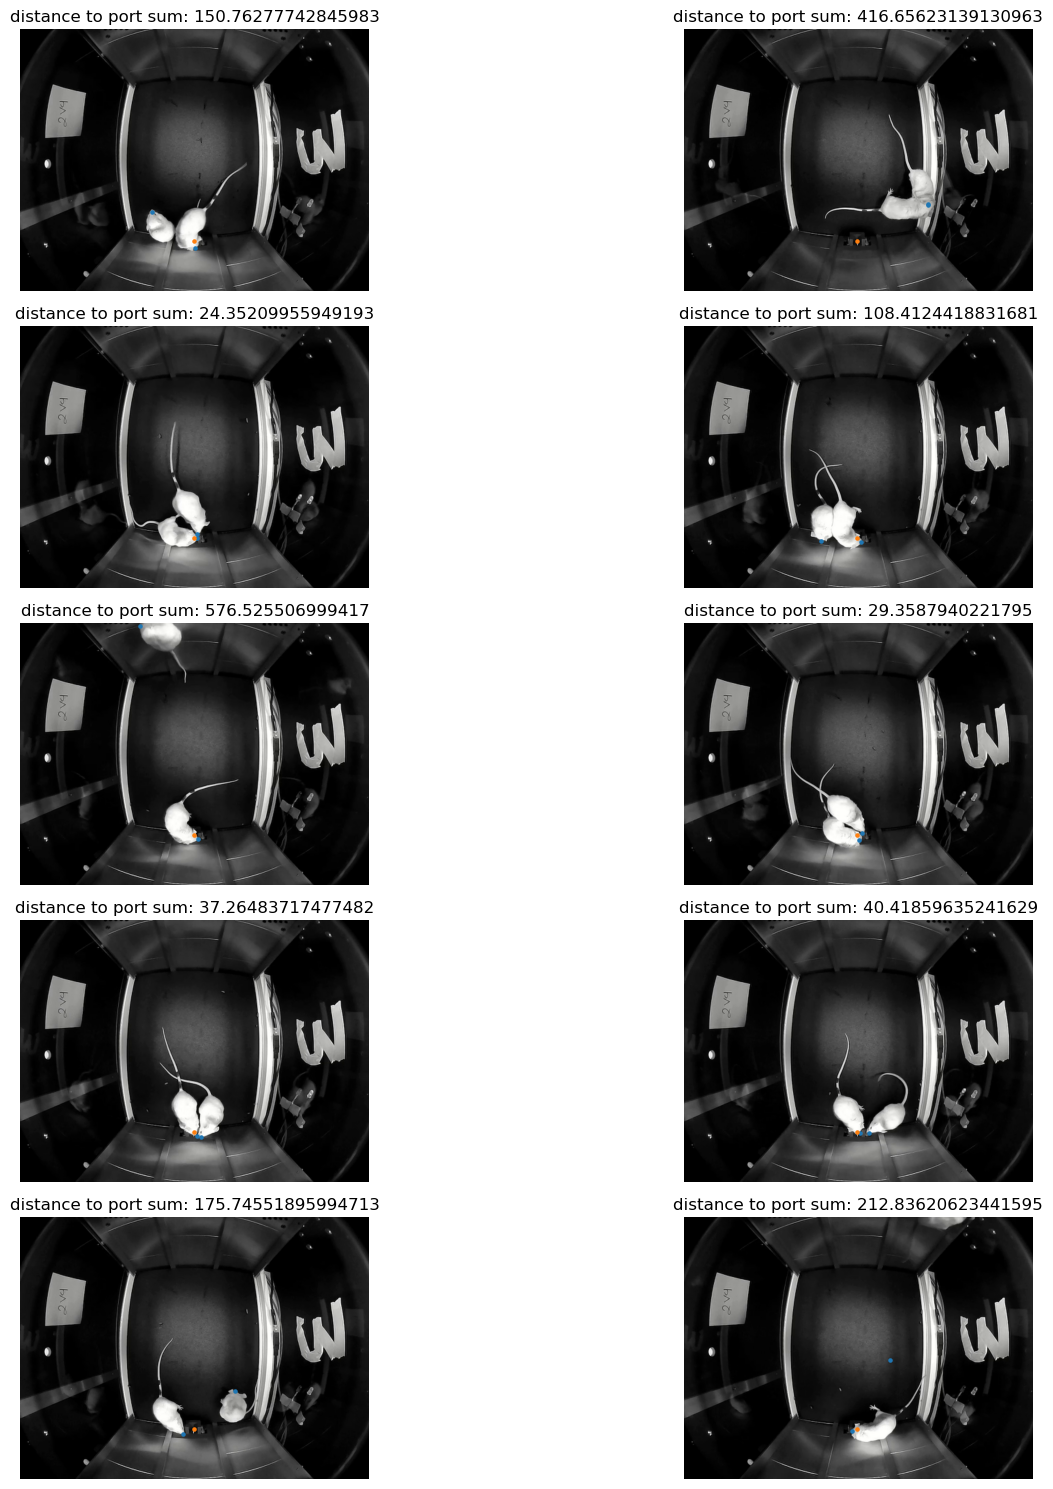

In [14]:

#Load your video using cv2.VideoCapture()
#pick random video file
cap = cv2.VideoCapture(r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\videos\10-03-22_Test_23_5-2v5-4.fixed.mp4')  # Replace 'your_video.mp4' with your video file
#insert video file base name 
file = '10-03-22_Test_23_5-2v5-4'
sleap = info[file]

#and pick feature (name must equal the name of your column)
feature = 'distance to port sum'
if not cap.isOpened(): 
    print("Could not open the video file!")
else:
    print("Video read successful!")
    success, image = cap.read()
    #only look at the parts of the dataframe for the recording youve chosen
    recording_df = df[df['Recording'] == file]
    # only look at the feature you want to visualize 
    my_array = np.array(recording_df[feature])
    # add one to frame list since frames are not actually zero indexed
    frame_list = np.arange(1, sleap.locations.shape[0]+1)
    # choose 10 random frames 
    random_frames = np.random.choice(frame_list, size=10, replace=False)
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    for idx, frame_num in enumerate(random_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)  # Frame indexing starts from 0
        success, image = cap.read()
        if success:
            # Convert BGR image to RGB for display with matplotlib
            frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Plot on the respective subplot
            row = idx // 2  # Calculate subplot row
            col = idx % 2  # Calculate subplot column
            axs[row, col].imshow(frame_rgb)
            axs[row, col].scatter(
                #pick nodes that you want to visualize, last dimenison is mouse
                #0 = mouse 1 , 1 = mouse 2, : = both mice 
                sleap.locations[frame_num, sleap.node_dict['nose'], 0, :],
                sleap.locations[frame_num, sleap.node_dict['nose'], 1, :],
                s=5
            )
            # add non mouse related points if desired 
            axs[row, col].scatter(box_setup[file]['reward_port'][0],
                                  box_setup[file]['reward_port'][1],s=5)
            # axs[row, col].scatter(box_setup[file]['bottom_left'][0],
            #                       box_setup[file]['bottom_left'][1],s=5)
            # axs[row, col].scatter(box_setup[file]['bottom_right'][0],
            #                       box_setup[file]['bottom_right'][1],s=5)
            # axs[row, col].scatter(
            #     sleap.locations[frame_num, sleap.node_dict['thorax'], 0, :],
            #     sleap.locations[frame_num, sleap.node_dict['thorax'], 1, :],
            #     s=5
            # )
            # axs[row, col].scatter(
            #     sleap.locations[frame_num, sleap.node_dict['forehead'], 0, :],
            #     sleap.locations[frame_num, sleap.node_dict['forehead'], 1, :],
            #     s=5)
            axs[row, col].axis('off')  # Turn off axis labels and ticks
            axs[row, col].set_title(f"{feature}: {my_array[frame_num]}")
    plt.tight_layout()  # Adjust subplot layout
    plt.show()
cap.release()


# UMAPS

### Color dictionary for labels

some functions to make color dictionaries for columns for plotting purposes 

In [10]:
def make_color_dict(column_name, df, cmap = 'gist_ncar'):
    unique_labels = df[column_name].unique()
    color_map = plt.cm.get_cmap(cmap, len(unique_labels))
    # Create a dictionary to map labels to colors
    label_color_dict = {label: color_map(i) for i, label in enumerate(unique_labels)}
    # Assign colors to each label based on the color map
    #colors = [label_color_dict[label] for label in recording_labels]
    #colors = np.array(colors)
    return label_color_dict

def show_palette(color_dict):
    colors = list(color_dict.values())
    palette = sns.color_palette(colors)
    sub_pallete_no = int(len(palette)//5)
    divided_palettes = [palette[i:i+5] for i in range(0, len(palette), 5)]  # Create 6 lists of 5 elements
    divided_palettes.append(palette[sub_pallete_no:])
    # Plotting color swatches for each label
    for color_palette in divided_palettes:
        sns.palplot(color_palette)  # Plotting color swatches for each sub-palette
        
        # Adding labels above the color swatches
        plt.xticks([])  # Hide x-axis ticks
        for color, label in zip(color_palette, list(color_dict.keys())):
            plt.text(color_palette.index(color), -0.5, label, ha='center', fontsize=8, rotation=45)

        plt.show()
recording_colors = make_color_dict('Recording', clustered_df)
strain_colors = {'C57': 'r', 'CD1':'b'}




## UMAP calls

Here is where you actually use dimensionality reduction (UMAP) techniques and clustering techniques. 

Things we tried: 

FOR UMAP/clustering order: 

    standard UMAP then clustering 

    enhanced UMAP then clustering 

clustering then UMAP (since UMAP is only used for visualizations in this case, the results do not depend on standard or enhanced)

FOR DATA TYPE/TRANSFORMATIONS:

    using zscored data

    using log transformed data

    using a mix 

FOR CLUSTERING TECHNIQUES:

    using kmean clustering

    using hdbscan clustering

Note: in theory, any dimensionality reduction technique can be used here, especially if clustering is done on the multidimensional data (i.e. z score data from all features)

We ended up using kmeans clustering on zscored data BEFORE using standard UMAP dimensionality reduction for visualization only. 

We made this choice based on interpretability of GIFs created. 

Code taken from https://umap-learn.readthedocs.io/en/latest/


In [13]:
# grab only the z score data as input to UMAP
zscore_df = subsample_df.iloc[:,7:14]

### Enhanced Clusterable UMAP

In [14]:
#enhanced clusterable embedding
clusterable_embedding_zscore = umap.UMAP(
    n_neighbors= 14,
    min_dist=0,
    n_components=2,
    random_state=42
).fit_transform(zscore_df)

### Standard Embedding UMAP

In [15]:
# standard embedding
standard_embedding_zscore = umap.UMAP(random_state=42).fit_transform(zscore_df)

In [101]:
#add both embeddings to master df 
subsample_df['embedding_zscore_x'] = clusterable_embedding_zscore[:,0]
subsample_df['embedding_zscore_y']= clusterable_embedding_zscore[:,1]
subsample_df['embedding_zscore_x_standard'] = standard_embedding_zscore[:,0]
subsample_df['embedding_zscore_y_standard'] = standard_embedding_zscore[:,1]

### Clustering Calls

In [17]:
# call kmeans clustering and hdbscan clustering 
# on z score data, standard embeddings, and enhanced embeddings 
#returns an array of numbers in the same order as the original dataframe of frames
hdbscan_labels_zscore = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7000, max_cluster_size=460000).fit_predict(clusterable_embedding_zscore)
kmeans_labels_zscore = cluster.KMeans(n_clusters=8).fit_predict(clusterable_embedding_zscore)
standard_hdbscan_labels_zscore = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7000, max_cluster_size=450000).fit_predict(standard_embedding_zscore)
raw_hdbscan_labels_zscore = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7000, max_cluster_size=450000).fit_predict(zscore_df)
kmeans_label_zscore = cluster.KMeans(n_clusters=8).fit_predict(zscore_df)

#n_cluster = number of clusters, experimentally we found 8 to be satisfactory 

In [18]:
standard_kmeans_labels_zscore = cluster.KMeans(n_clusters=10).fit_predict(standard_embedding_zscore)

In [102]:
# add the cluster labels to the master dataframe 
subsample_df['standard_kmeans_labels_zscore'] = standard_kmeans_labels_zscore
subsample_df['standard_hdbscan_labels_zscore'] =  standard_hdbscan_labels_zscore
subsample_df['enhanced_kmeans_labels_zscore'] = kmeans_labels_zscore
subsample_df['enhanced_hdbscan_labels_zscore'] = hdbscan_labels_zscore
subsample_df['raw_kmeans_labels_zscore'] = kmeans_label_zscore
subsample_df['raw_hdbscan_labels_zscore'] = raw_hdbscan_labels_zscore


In [123]:
# with open('subsample_df.pkl', 'wb') as file:
#      pickle.dump(subsample_df, file)
# with open('subsample_df.pkl', 'rb') as file:
#     subsample_df = pickle.load(file)

# save the data to a csv.
file = 'rewardcomp_cluster_df.csv'
subsample_df.to_csv(file)

In [96]:
#clustered_df = subsample_df
clustered_dataset = len(clustered_df) 
# pick every 10th frame for plotting (otherwise hard to see the layered colors)
# we have a LOT of data 
random_subsample = np.random.choice(clustered_dataset, size=(clustered_dataset//10), replace = False)
subsample_cluster_df = clustered_df.iloc[random_subsample]
# also grab only the trial data for visualization purposes 
trial_df = clustered_df[clustered_df['trial_indice'].astype(float) > 0]

## Cluster plots

### KMeans clusters

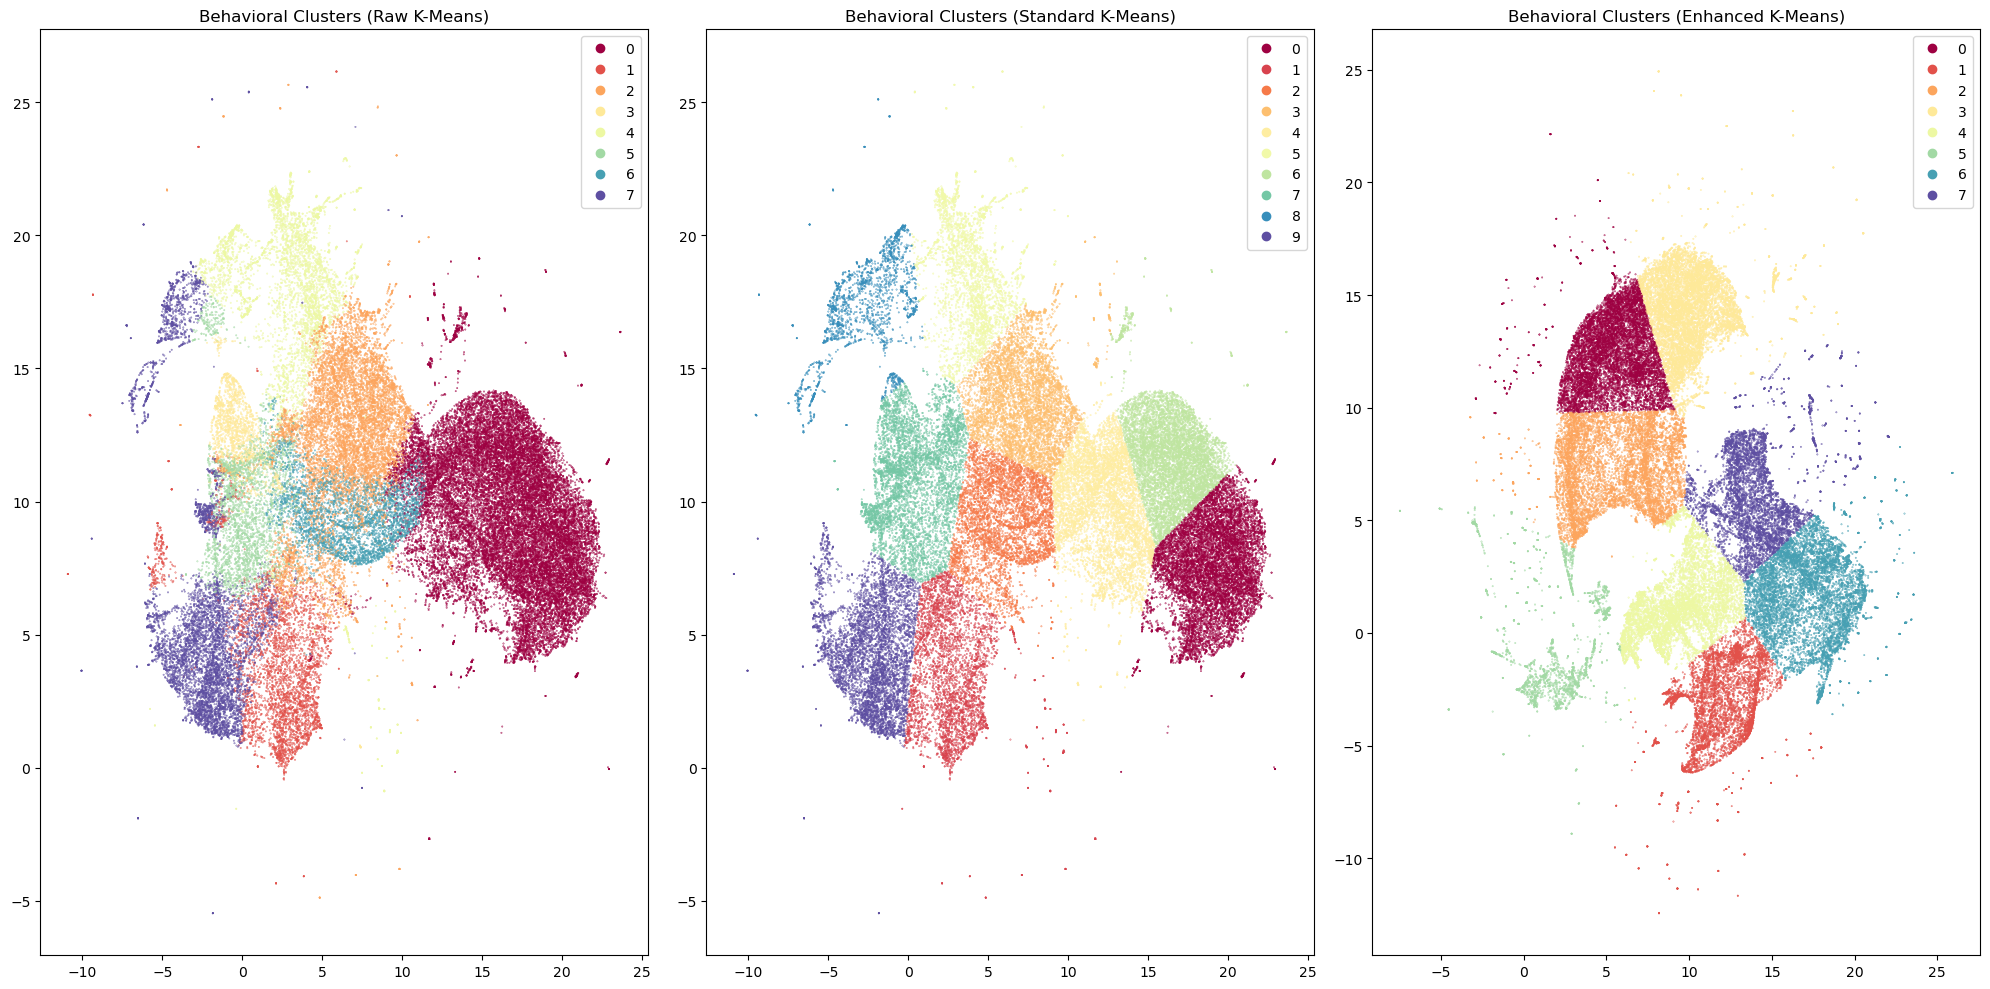

In [23]:
# visualize cluster outputs for standard embedding, enhanced embedding, and zscore labels 
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

standard_clustered_zscore = subsample_df[subsample_df['standard_hdbscan_labels_zscore'] >= 0]
raw_clustered_zscore = subsample_df[subsample_df['raw_hdbscan_labels_zscore'] >= 0]

# Plot scatter plots on each subplot
scatter1 = axs[0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['raw_kmeans_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[0].set_title('Behavioral Clusters (Raw K-Means)')
axs[0].legend(*scatter1.legend_elements(), bbox_to_anchor=(1, 1))

scatter2 = axs[1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['standard_kmeans_labels_zscore'],
                             s=0.1,
                             cmap = 'Spectral')
axs[1].set_title('Behavioral Clusters (Standard K-Means)')
axs[1].legend(*scatter2.legend_elements(), bbox_to_anchor=(1, 1))

scatter3 = axs[2].scatter(subsample_cluster_df['embedding_zscore_x'],
                             subsample_cluster_df['embedding_zscore_y'],
                             c=subsample_cluster_df['enhanced_kmeans_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[2].set_title('Behavioral Clusters (Enhanced K-Means)')
axs[2].legend(*scatter3.legend_elements(), bbox_to_anchor=(1, 1))



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### HDBScan Clusters

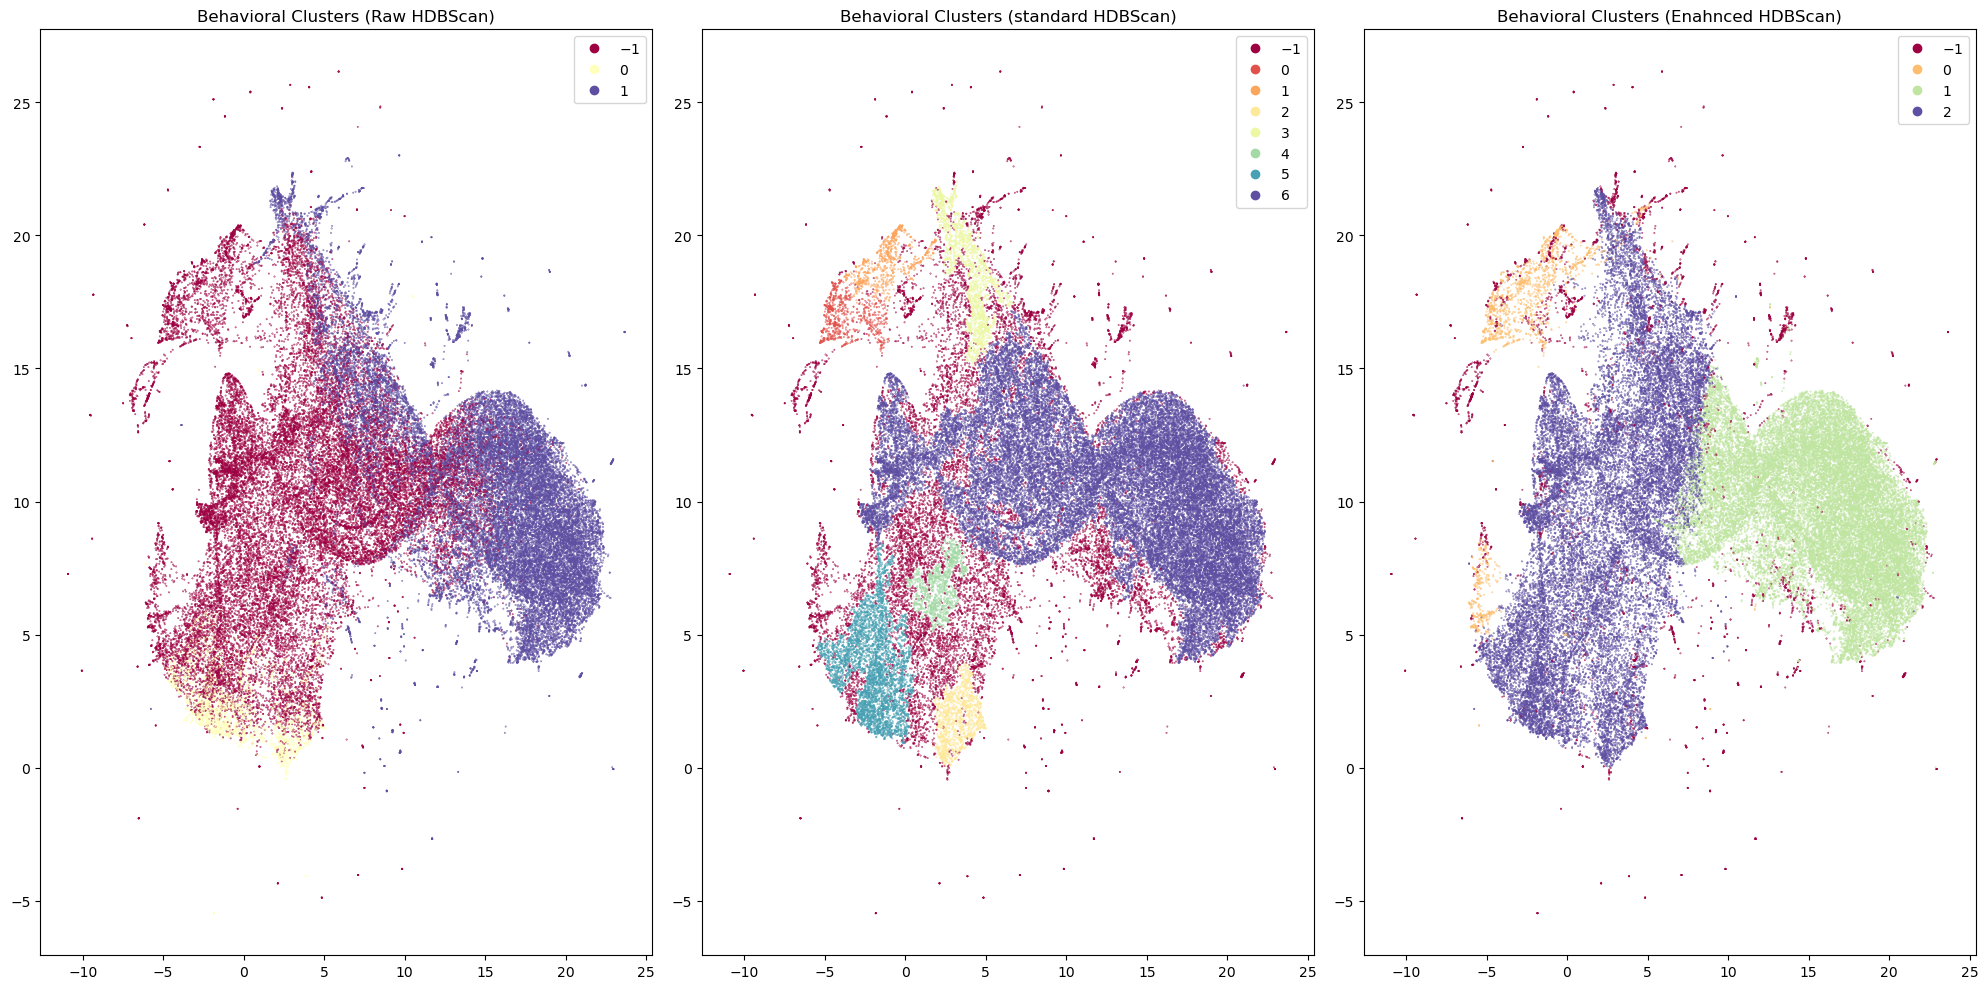

In [24]:
# same thing as above but for hdbscan labels
# Note: -1 = unclustered for labels
standard_clustered_zscore = subsample_df[subsample_df['standard_hdbscan_labels_zscore'] >= 0]
raw_clustered_zscore = subsample_df[subsample_df['raw_hdbscan_labels_zscore'] >= 0]

fig, axs = plt.subplots(1, 3, figsize=(20, 10))

scatter1 = axs[0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['raw_hdbscan_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[0].set_title('Behavioral Clusters (Raw HDBScan)')
axs[0].legend(*scatter1.legend_elements(), bbox_to_anchor=(1, 1))

scatter2 = axs[1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['standard_hdbscan_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[1].set_title('Behavioral Clusters (standard HDBScan)')
axs[1].legend(*scatter2.legend_elements(), bbox_to_anchor=(1, 1))


scatter3 = axs[2].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['enhanced_hdbscan_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[2].set_title('Behavioral Clusters (Enahnced HDBScan)')
axs[2].legend(*scatter3.legend_elements(), bbox_to_anchor=(1, 1))



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Feature overlay plots

ValueError: cannot convert float NaN to integer

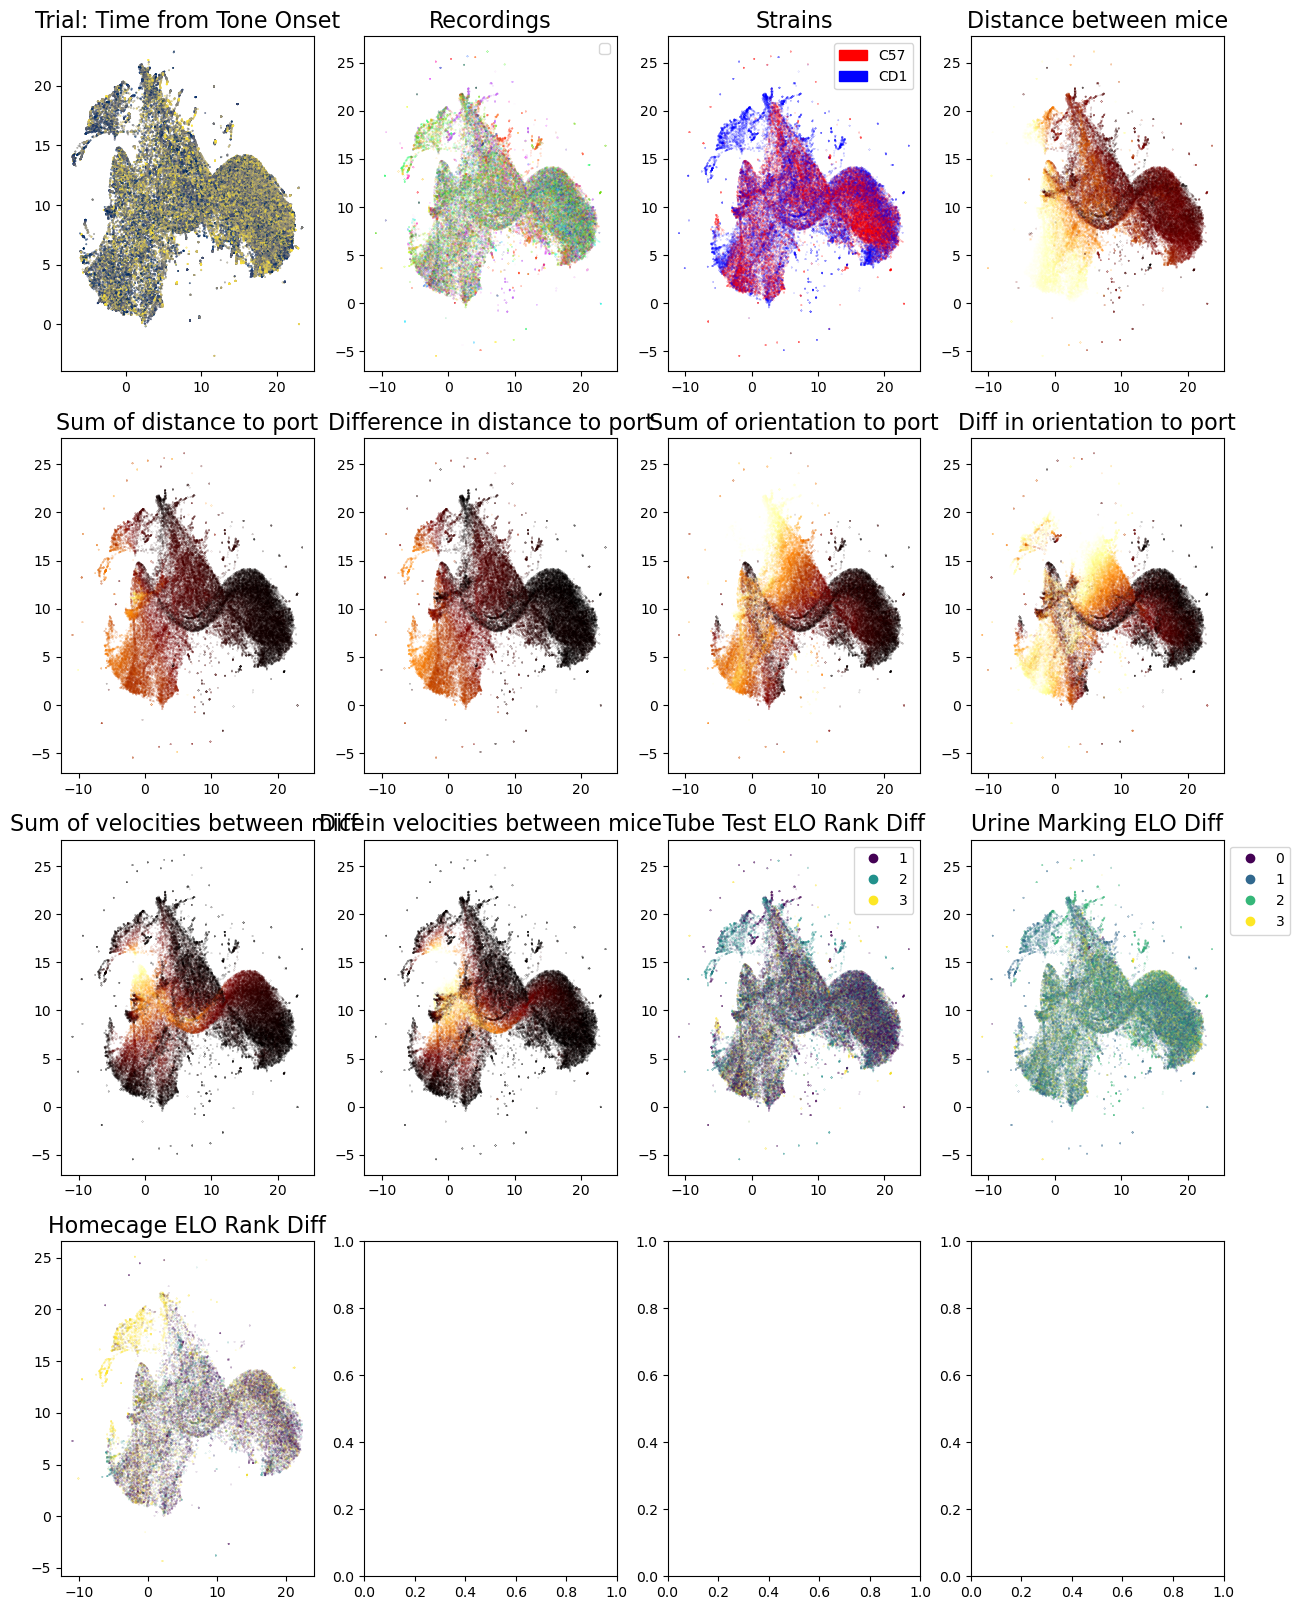

In [25]:
# visualize how the features differ for each cluster by plotting features
# also plot recordings, strains, and trial indices overlaid on the standard embedding 
# aka features, strain, recording, trial indices, elo rank diff, etc. are all mapped to colors 
from matplotlib.patches import Patch
# create a figure with 4x4 subplots 
fig, ax = plt.subplots(4, 4, figsize=(15, 20))
# ax[0,0] = first left most plot 
scatter1 = ax[0,0].scatter(trial_df['embedding_zscore_x_standard'],
            trial_df['embedding_zscore_y_standard'],
            # map trial indice to c aka color
            c=trial_df['trial_indice'].astype(float),
            s=0.1,
            cmap='cividis')
ax[0,0].set_title('Trial: Time from Tone Onset', fontsize= 16)

# ax[0,1] = second plot (top row, second column)
scatter2 = ax[0,1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            # map recording column to recording color dict
            # and assign to c (color)
            c=subsample_cluster_df['Recording'].map(recording_colors),
            label = subsample_cluster_df['Recording'],
            s=0.005)   
ax[0,1].set_title('Recordings', fontsize= 16)
legend2 = ax[0,1].legend(*scatter2.legend_elements(), bbox_to_anchor = (1,1))

scatter3 = ax[0,2].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            # map strain column to strain color dict
            c=subsample_cluster_df['Strain'].map(strain_colors),
            label=subsample_cluster_df['Strain'],
            s=0.005)  
ax[0,2].set_title('Strains', fontsize= 16)
legend_handles3 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
legend3 = ax[0,2].legend(handles = legend_handles3, bbox_to_anchor = (1,1))

# assign each feature column to c 
scatter4 = ax[0,3].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['thorax distances'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 400)  
ax[0,3].set_title('Distance between mice', fontsize= 16)

scatter5 = ax[1,0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['distance to port sum_zscore'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 6)  
ax[1,0].set_title('Sum of distance to port', fontsize= 16)

scatter6 = ax[1,1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['distance to port diff_zscore'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 6)  
ax[1,1].set_title('Difference in distance to port', fontsize= 16)

scatter7 = ax[1,2].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['orientation to port sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax=7)  
ax[1,2].set_title('Sum of orientation to port', fontsize= 16)

scatter8 = ax[1,3].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['orientation to port diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 4)  
ax[1,3].set_title('Diff in orientation to port', fontsize= 16)

scatter9 = ax[2,0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['mouse velocity sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 20)  
ax[2,0].set_title('Sum of velocities between mice', fontsize= 16)

scatter10 = ax[2,1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['mouse velocity diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 12.5)  
ax[2,1].set_title('Diff in velocities between mice', fontsize= 16)

scatter11 = ax[2,2].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['tube_test_elo'].astype(float),
            s=0.005)  
ax[2,2].set_title('Tube Test ELO Rank Diff', fontsize= 16)
legend11 = ax[2,2].legend(*scatter11.legend_elements(), bbox_to_anchor = (1,1))


scatter12 = ax[2,3].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['urine_marking_elo'].astype(float),
            s=0.005)  
ax[2,3].set_title('Urine Marking ELO Diff', fontsize= 16)
legend12 = ax[2,3].legend(*scatter12.legend_elements(), bbox_to_anchor = (1,1))


scatter13 = ax[3,0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['home_cage_observation_elo'].astype(float),
            s=0.005)  
ax[3,0].set_title('Homecage ELO Rank Diff', fontsize= 16)
legend13 = ax[3,0].legend(*scatter13.legend_elements(), bbox_to_anchor = (1,1))

scatter14 = ax[3,1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['reward_comp_elo'].astype(float),
            s=0.005)  
ax[3,1].set_title('Reward Comp ELO rank diff', fontsize= 16)
legend14 = ax[3,1].legend(*scatter14.legend_elements(), bbox_to_anchor = (1,1))



# add color bars for the feature plots (gradient/spectrum)
# do not need color bars for categorical data 
plt.colorbar(scatter1, ax=ax[0,0]) 
plt.colorbar(scatter4, ax=ax[0,3]) 
plt.colorbar(scatter5, ax=ax[1,0]) 
plt.colorbar(scatter6, ax=ax[1,1]) 
plt.colorbar(scatter7, ax=ax[1,2]) 
plt.colorbar(scatter8, ax=ax[1,3]) 
plt.colorbar(scatter9, ax=ax[2,0]) 
plt.colorbar(scatter10, ax=ax[2,1]) 


#legend_handles4 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
#legend3 = ax[3].legend(handles = legend_handles3)
plt.savefig('./feature_clusters.png')
plt.show()


### Figure plotting for Paper

plotting code for paper ready plots

([], <a list of 0 Text major ticklabel objects>)

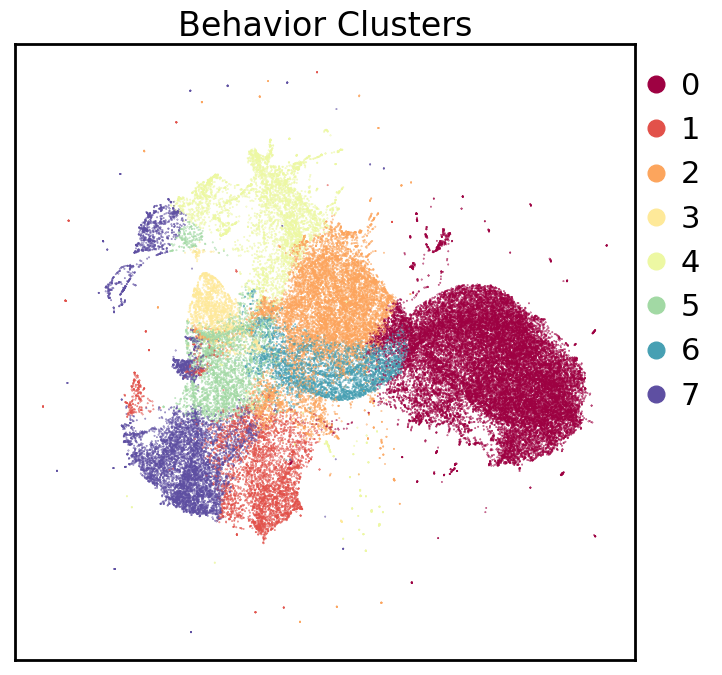

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
scatter = plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['raw_kmeans_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
plt.title('Behavior Clusters', fontsize = 24)
legend = plt.legend(*scatter.legend_elements(),
                    bbox_to_anchor=(.94, 1),
                    frameon = False,
                    fontsize = 22,
                    markerscale = 2,
                    ncol = 1,
                    handletextpad = -0.2,
                    columnspacing = 0.2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

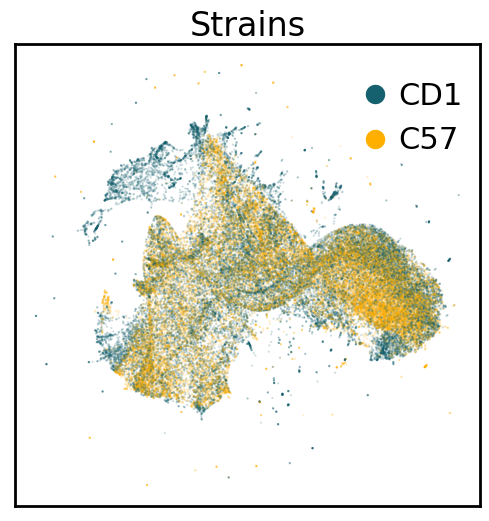

In [13]:
from matplotlib.lines import Line2D 
fig, ax = plt.subplots(figsize=(6, 6))
strain_colors = {'CD1': hex_2_rgb('#15616F'), 'C57': hex_2_rgb('#FFAF00')}
strain_alphas = {'CD1':0, 'C57':0.5}
scatter = plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['Strain'].map(strain_colors),
            #label=subsample_cluster_df['Strain'],
            s=.3, alpha = .2)  
plt.title('Strains', fontsize= 24)
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                   for label, color in strain_colors.items()]
#legend_handles3 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
plt.legend(handles = legend_handles,
           bbox_to_anchor = (.65,.7),
           frameon= False,
           fontsize = 22,
           markerscale = 1.5,
           handletextpad=-.25)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

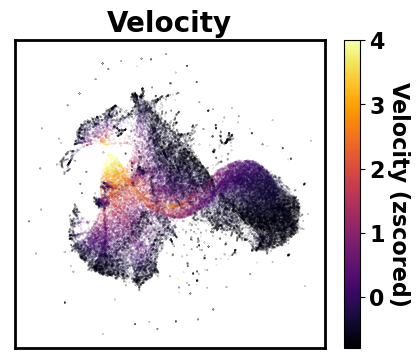

In [103]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['mouse velocity sum_zscore'].astype(float),
            s=0.005, cmap = 'inferno', vmax = 4)  
cbar = plt.colorbar()
plt.title('Velocity', fontsize= 20)
cbar.set_label(label = 'Velocity (zscored)', fontsize = 16, rotation = 270)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.labelpad = 18
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

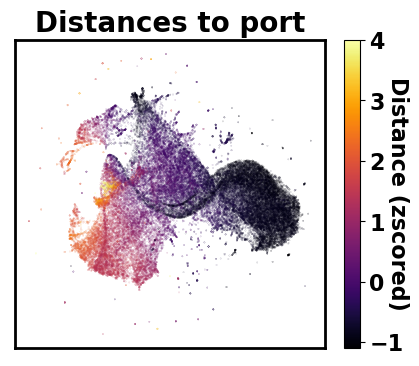

In [102]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['distance to port sum_zscore'].astype(float),
            s=0.005, cmap = 'inferno', vmax = 4)  

plt.title('Distances to port', fontsize= 20)
cbar = plt.colorbar()
cbar.set_label(label = 'Distance (zscored)', fontsize = 16, rotation = 270)
cbar.ax.tick_params(labelsize=16)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

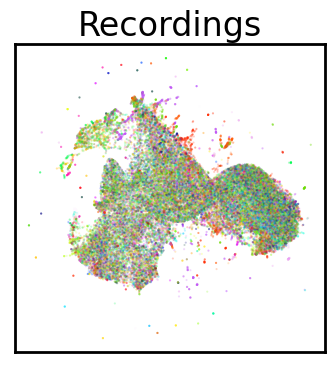

In [18]:
fig, ax = plt.subplots(figsize=(4, 4))
#strain_colors = {'CD1': hex_2_rgb('#15616F'), 'C57': hex_2_rgb('#FFAF00')}
#strain_alphas = {'CD1':0, 'C57':0.5}
scatter = plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['Recording'].map(recording_colors),
            #label=subsample_cluster_df['Strain'],
            s=.3, alpha = .2)  
plt.title('Recordings', fontsize= 24)
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                   for label, color in strain_colors.items()]
#legend_handles3 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
#plt.legend(handles = legend_handles,
        #    bbox_to_anchor = (.65,.7),
        #    frameon= False,
        #    fontsize = 22,
        #    markerscale = 1.5,
        #    handletextpad=-.25)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

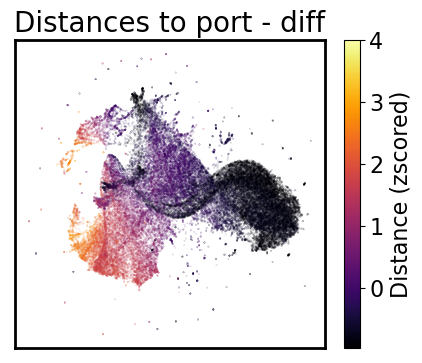

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['distance to port diff_zscore'].astype(float),
            s=0.005, cmap = 'inferno', vmax = 4)  

plt.title('Distances to port - diff', fontsize= 20)
cbar = plt.colorbar()
cbar.set_label(label = 'Distance (zscored)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

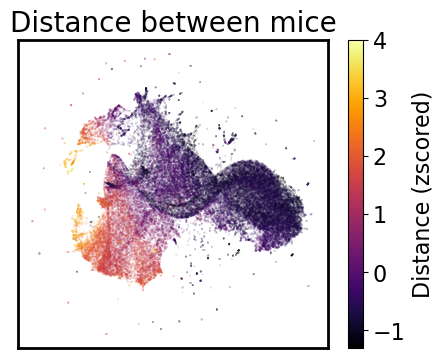

In [22]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['thorax distances_zscore'].astype(float),
            s=0.005, cmap = 'inferno', vmax = 4)  

plt.title('Distance between mice', fontsize= 20)
cbar = plt.colorbar()
cbar.set_label(label = 'Distance (zscored)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

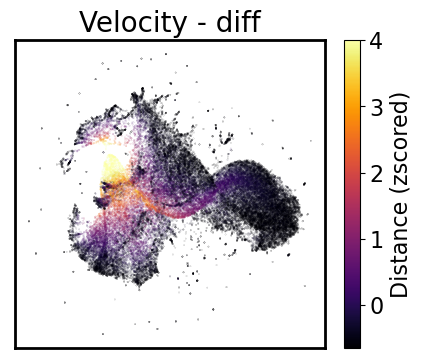

In [24]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['mouse velocity diff_zscore'].astype(float),
            s=0.005, cmap = 'inferno', vmax = 4)  

plt.title('Velocity - diff', fontsize= 20)
cbar = plt.colorbar()
cbar.set_label(label = 'Distance (zscored)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

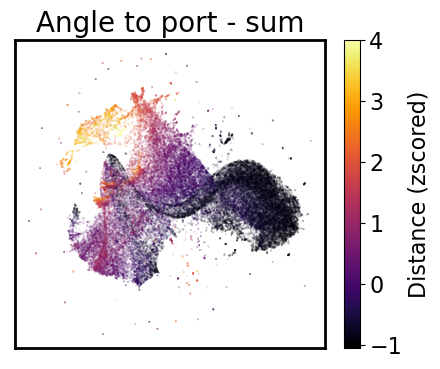

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['orientation to port sum_zscore'].astype(float),
            s=0.005, cmap = 'inferno', vmax = 4)  

plt.title('Angle to port - sum', fontsize= 20)
cbar = plt.colorbar()
cbar.set_label(label = 'Distance (zscored)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

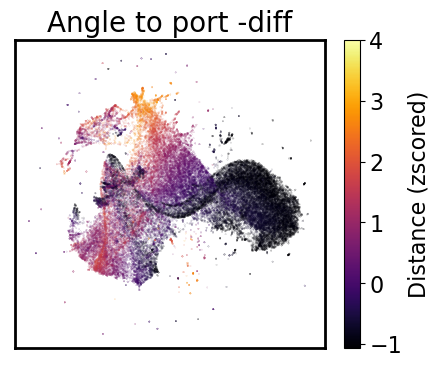

In [27]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['orientation to port diff_zscore'].astype(float),
            s=0.005, cmap = 'inferno', vmax = 4)  

plt.title('Angle to port -diff', fontsize= 20)
cbar = plt.colorbar()
cbar.set_label(label = 'Distance (zscored)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

## GIF Creation

The below functions take in a dataframe of frame indices and cluster labels and creates either .gif or .avi files of randomly selected frames from each cluster for user interpretation. 
Of note: every video will need to be on the local computer running this code. 

In [ ]:
def cluster_gifs(all_cluster_df,
                 cluster_label,
                 length,
                 vid_folder,
                 output_directory,
                 file_type):
    """
    Takes in a dataframe with frame indices as a column labeled frame indice, 
    Recording filename as a column labeled Recording, and creates a .gif or .avi 
    file for each cluster and saves them in the output_directory

    Args (6):
        all_cluster_df: pandas dataframe with recording, frame indices 
            and cluster info
        cluster_label:str, name of column of cluster labels
        length: int, length of gif or avi in seconds
        vid_folder: str, path to where the videos are stored
        output_directory: str, path to where the new vids or 
            gifs will be saved
        file_type: str, either {.gif, .avi}, to get either a GIF 
            or a video
    
    Returns:
        None
    """
    create_output_directory(output_directory)
    no_clusters = len(all_cluster_df[cluster_label].unique())
    i = 1
    for cluster in all_cluster_df[cluster_label].unique():
        print(f'working on {i} out of {no_clusters} clusters')
        cluster_df = all_cluster_df[all_cluster_df[cluster_label] == cluster]
        random_indices = np.random.choice(len(cluster_df), size=length*30, replace=False)
        gif_df = cluster_df.iloc[random_indices]
        #gif_df.to_excel(os.path.join('tester.xlsx', output_directory))
        grouped = gif_df.groupby('Recording')['frame indice'].apply(list).reset_index()
        frames_df = grouped.apply(lambda row: extract_frames(row['Recording'],
                                       row['frame indice'],
                                       vid_folder),
                                axis = 1)
        create_gif(cluster, frames_df, output_directory, file_type)
        i+=1

def find_vid(vid_name, folder):
    """
    Takes in vid_name and folder and finds a video. This only works when the 
    recording filename is the same as the video filename.

    Args (2):
        vid_name: str, name of video/recording file (no .mp4 ending)
        folder: str, path to folder with all the videos
    
    Returns (1):
        video_path:str, path to the specific video for a given
            recording
    """
    ending = ".mp4"
    for filename in os.listdir(folder):
        if filename.endswith(ending) and vid_name in filename:
            video_path = os.path.join(folder, filename)
    return video_path

def extract_frames(vid_name, frame_list, directory):
    """
    Takes in a vid/recording name, a list of frame indices, and where the 
    video is saved and returns a list of frames.

    Args (3):
        vid_name: str, name of video (no .mp4 ending)
        frame_list: list of ints, frame indices of the returned frames
        directory: str, path to all the videos 
    
    Returns:
        frames: list, a list of frame instances 
    """
    # Open the video file
    video_path = find_vid(vid_name, directory)
    cap = cv2.VideoCapture(video_path)
    frames = []
    for frame_index in frame_list:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(float(frame_index))-1)
        success, frame = cap.read()
        if success:
            resized_frame = cv2.resize(frame, (640, 480))
            frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
    cap.release()
    return frames
        
def create_gif(cluster, frames_df, output_directory, file_type):
    """
    Creates and saves gifs or videos for a given cluster. 

    Args (4):
        cluster: int, cluster
        frames_df: pandas df, dataframe containing recording names
            and frame instances
        output_directory: str, path to where the videos will be saved
        file_type: str, {.avi, .gif} for video or gif output

    Returns:
        none 
    """
    gif_frames = []
    for recording in range(len(frames_df.index)):
        row = frames_df.loc[recording]
        i = 0
        for frame in row:
            gif_frames.append(frame)
            i +=1
    gif_path = os.path.join(output_directory, f"cluster{cluster}{file_type}")
    if file_type == '.gif':
        imageio.mimsave(gif_path, gif_frames, format='GIF', duration=3)
    else:
        imageio.mimsave(gif_path, gif_frames, format='FFMPEG')
    

def create_output_directory(output_directory):
    """
    Create the output directory if it does not exist.
    Prints out statement if new directory has been created or if 
    failed to create output_directory if output_directory does not exist.

    Args (1):
        output_dir: str, the path of the output directory to be created.

    Returns:
        none
    """
    # Check if the directory exists
    if not os.path.exists(output_directory):
        try:
            # Create the directory
            os.makedirs(output_directory)
            print(f"Output directory '{output_directory}' created successfully.")
        except OSError as e:
            print(f"Error: Could not create output directory '{output_directory}': {e}")
    else:
        pass


vid_folder = r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\videos'
output_directory = r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\results\minus_c57_vid\cluster_gifs_zscore_raw'
cluster_gifs(subsample_df,
             cluster_label = 'raw_kmeans_labels_zscore',
             length = 5,
             vid_folder=vid_folder,
             output_directory=output_directory, 
             file_type = '.avi')


## Cluster Analysis

here is some cluster analysis code - including strain break down per cluster, rank difference per cluster etc. 

In [86]:
plt.rcParams.update({
    'font.weight': 'bold',    # Set the default font weight to bold
    'axes.labelweight': 'bold',  # Set the default axes label font weight to bold
    'axes.titleweight': 'bold'})

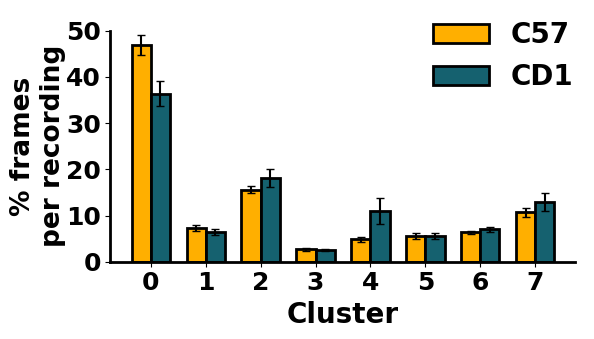

In [91]:
# calculate % cluster for each recording 
# group by cluster label and recording
recording_grouping =  clustered_df.groupby(['raw_kmeans_labels_zscore','Recording'])
# calculate total frames per cluster within each recording
cluster_per_recording_counts = recording_grouping['Recording'].value_counts().unstack() 
# calculate percent cluster within each recording
cluster_per_recording_percentages = cluster_per_recording_counts.div(
    cluster_per_recording_counts.sum(axis=0), axis=1) * 100
cluster_per_recording_percentages.columns 
cd1_percentages = cluster_per_recording_percentages[['10-03-22_Test_11_6-1v6-2', '10-03-22_Test_12_6-3v6-4',
                                            '10-03-22_Test_23_5-2v5-4', '10-03-22_Test_24_5-1v5-3',
                                            '10-03-22_Test_35_6-2v6-3',  '10-04-22_Test_13_5-1v5-3',
                                            '10-03-22_Test_7_4-1v4-2', '10-03-22_Test_8_4-3v4-4',
                                            '10-04-22_Test_14_5-2v5-4', '10-04-22_Test_15_6-1v6-3',
                                            '10-04-22_Test_16_6-2v6-4', '10-04-22_Test_2_6-2v6-3',
                                            '10-04-22_Test_19_4-1v4-3', '10-04-22_Test_20_4-2v4-4',
                                             '10-04-22_Test_3_5-1v5-4']]

c57_percentages = cluster_per_recording_percentages[['10-03-22_Test_13_2-2v2-4', '10-03-22_Test_14_2-1v2-3',
                                            '10-03-22_Test_15_1-2v1-4', '10-03-22_Test_19_3-2v3-4',
                                            '10-03-22_Test_1_1-1v1-2', '10-03-22_Test_20_3-1v3-3',
                                            '10-03-22_Test_2_1-3v1-4', '10-03-22_Test_32_4-1v4-4',
                                            '10-03-22_Test_3_2-1v2-2',  '10-04-22_Test_12_1-2v1-3',
                                            '10-04-22_Test_10_2-2v2-3', '10-04-22_Test_11_1-1v1-4',
                                            '10-04-22_Test_17_3-1v3-3',   '10-04-22_Test_21_1-1v1-3', 
                                            '10-04-22_Test_8_3-2v3-3', '10-04-22_Test_9_2-1v2-4',
                                            '10-04-22_Test_7_3-1v3-4']]
num_clusters = cluster_per_recording_counts.shape[0]

# Set the width of each bar
bar_width = 0.35

# Create an array of cluster indices
cluster_indices = np.arange(num_clusters) 
# calculate averaeg and SEM for both strains        
cd1_mean = cd1_percentages.mean(axis = 1)
cd1_sem = cd1_percentages.sem(axis = 1)
c57_mean = c57_percentages.mean(axis = 1)
c57_sem = c57_percentages.sem(axis = 1)

# plot average % cluster per recordings per strain 
# in a double bar chart 
fig, ax = plt.subplots(figsize=(6, 3))
bar1 = ax.bar(cluster_indices - bar_width/2, c57_mean, 
              bar_width, label='C57', 
              color = hex_2_rgb('#FFAF00'), 
              edgecolor = 'k', yerr = c57_sem,
              linewidth = 2,
              capsize = 3)
bar2 = ax.bar(cluster_indices + bar_width/2, cd1_mean, 
              bar_width, label='CD1',
              color = hex_2_rgb('#15616F'),
              edgecolor = 'k', yerr = cd1_sem,
              linewidth = 2,
              capsize = 3)



ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylim(0,50)
#ax.set_yticks(range(0,7,2))
ax.set_ylabel('% frames\nper recording', fontsize = 19, labelpad = 0)
#ax.set_title('Strain Percentage per Cluster', fontsize = 24)
ax.set_xticks(cluster_indices)
ax.legend(frameon = False, fontsize = 20, bbox_to_anchor = (1.05,1.15))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
# Show plot
plt.show()

       

In [78]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu

# run t test withs a bonferroni holms adjustment on the means across strains per cluster 
p_values = []
t_stats = []
mann_values = []
mann_statistics = []
cd1_percentages
for i in range(8):
    # Compute t-statistic and p-value
    t_statistic, p_value = ttest_ind(cd1_percentages.iloc[i,:], c57_percentages.iloc[i,:])
    p_values.append(p_value)
    t_stats.append(t_statistic)   
    mann_statistic, mann_value = mannwhitneyu(cd1_percentages.iloc[i,:], c57_percentages.iloc[i,:])
    mann_values.append(mann_value)
    mann_statistics.append(mann_statistic)


adjusted_p_values = multipletests(p_values, method='holm')[1]
adjusted_mann_values = multipletests(mann_values, method = 'holm')[1]


print(adjusted_p_values)
ttest_results = pd.DataFrame({"CD1": cd1_mean,
                              "CD1 SEM": cd1_sem,
                              "C57": c57_mean,
                              "C57 SEM": c57_sem,
                              "ttests": t_stats,
                              "pvalues": p_values,
                              "adjp": adjusted_p_values,
                              "mann p": adjusted_mann_values})
ttest_results
                             

[0.03817291 1.         1.         1.         0.22827894 1.
 1.         1.        ]


CD1   CD1 SEM        C57   C57 SEM    ttests  \
raw_kmeans_labels_zscore                                                       
0                         36.380026  2.750323  46.843143  2.124846 -3.048292   
1                          6.432773  0.678812   7.339171  0.706042 -0.919386   
2                         18.167261  1.968707  15.600841  0.819990  1.256833   
3                          2.561263  0.226726   2.680895  0.295036 -0.315044   
4                         10.932051  2.826801   4.836314  0.579744  2.240568   
5                          5.614207  0.596039   5.599682  0.601307  0.017076   
6                          6.982437  0.585208   6.412409  0.345256  0.862828   
7                         12.929981  1.869949  10.687545  0.901472  1.121746   

                           pvalues      adjp    mann p  
raw_kmeans_labels_zscore                                
0                         0.004772  0.038173  0.073364  
1                         0.365227  1.000000  1.000000  
2                         0.218512  1.000000  1.000000  
3                         0.754910  1.000000  1.000000  
4                         0.032611  0.228279  0.985735  
5                         0.986489  1.000000  1.000000  
6                         0.395077  1.000000  1.000000  
7                         0.270869  1.000000  1.000000

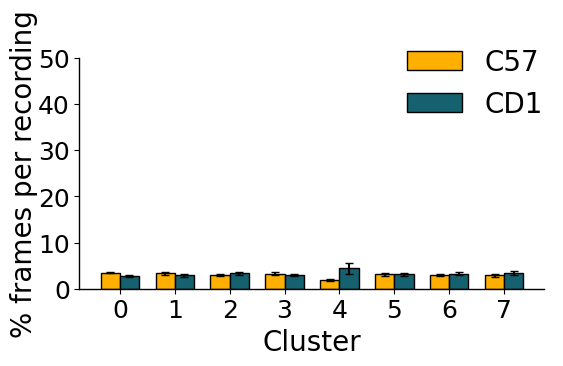

In [74]:
recording_grouping =  clustered_df.groupby(['raw_kmeans_labels_zscore','Recording'])
cluster_per_recording_counts = recording_grouping['Recording'].value_counts().unstack() 
cluster_per_recording_percentages = cluster_per_recording_counts.div(
    cluster_per_recording_counts.sum(axis=1), axis=0) * 100
cluster_per_recording_percentages.columns
cd1_percentages = cluster_per_recording_percentages[['10-03-22_Test_11_6-1v6-2', '10-03-22_Test_12_6-3v6-4',
                                            '10-03-22_Test_23_5-2v5-4', '10-03-22_Test_24_5-1v5-3',
                                            '10-03-22_Test_35_6-2v6-3',  '10-04-22_Test_13_5-1v5-3',
                                            '10-03-22_Test_7_4-1v4-2', '10-03-22_Test_8_4-3v4-4',
                                            '10-04-22_Test_14_5-2v5-4', '10-04-22_Test_15_6-1v6-3',
                                            '10-04-22_Test_16_6-2v6-4', '10-04-22_Test_2_6-2v6-3',
                                            '10-04-22_Test_19_4-1v4-3', '10-04-22_Test_20_4-2v4-4',
                                             '10-04-22_Test_3_5-1v5-4']]

c57_percentages = cluster_per_recording_percentages[['10-03-22_Test_13_2-2v2-4', '10-03-22_Test_14_2-1v2-3',
                                            '10-03-22_Test_15_1-2v1-4', '10-03-22_Test_19_3-2v3-4',
                                            '10-03-22_Test_1_1-1v1-2', '10-03-22_Test_20_3-1v3-3',
                                            '10-03-22_Test_2_1-3v1-4', '10-03-22_Test_32_4-1v4-4',
                                            '10-03-22_Test_3_2-1v2-2',  '10-04-22_Test_12_1-2v1-3',
                                            '10-04-22_Test_10_2-2v2-3', '10-04-22_Test_11_1-1v1-4',
                                            '10-04-22_Test_17_3-1v3-3',   '10-04-22_Test_21_1-1v1-3', 
                                            '10-04-22_Test_8_3-2v3-3', '10-04-22_Test_9_2-1v2-4',
                                            '10-04-22_Test_7_3-1v3-4']]
num_clusters = cluster_per_recording_counts.shape[0]

# Set the width of each bar
bar_width = 0.35

# Create an array of cluster indices
cluster_indices = np.arange(num_clusters) 
       
cd1_mean = cd1_percentages.mean(axis = 1)
cd1_sem = cd1_percentages.sem(axis = 1)
c57_mean = c57_percentages.mean(axis = 1)
c57_sem = c57_percentages.sem(axis = 1)

fig, ax = plt.subplots(figsize=(6, 3))
bar1 = ax.bar(cluster_indices - bar_width/2, c57_mean, 
              bar_width, label='C57', 
              color = hex_2_rgb('#FFAF00'), 
              edgecolor = 'k', yerr = c57_sem,
              capsize = 3)
bar2 = ax.bar(cluster_indices + bar_width/2, cd1_mean, 
              bar_width, label='CD1',
              color = hex_2_rgb('#15616F'),
              edgecolor = 'k', yerr = cd1_sem,
              capsize = 3)



ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylim(0,50)
#ax.set_yticks(range(0,7,2))
ax.set_ylabel('% frames per recording', fontsize = 20, labelpad = 0)
#ax.set_title('Strain Percentage per Cluster', fontsize = 24)
ax.set_xticks(cluster_indices)
ax.legend(frameon = False, fontsize = 20, bbox_to_anchor = (1.05,1.15))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['bottom'].set_linewidth(1)  # X-axis
plt.gca().spines['left'].set_linewidth(1) 
# Show plot
plt.show()

In [75]:
p_values = []
t_stats = []
cd1_percentages
for i in range(8):
    # Compute t-statistic and p-value
    t_statistic, p_value = ttest_ind(cd1_percentages.iloc[i,:], c57_percentages.iloc[i,:])
    p_values.append(p_value)
    t_stats.append(t_statistic)    


adjusted_p_values = multipletests(p_values, method='holm')[1]

print(adjusted_p_values)
ttest_results = pd.DataFrame({"CD1": cd1_mean,
                              "CD1 SEM": cd1_sem,
                              "C57": c57_mean,
                              "C57 SEM": c57_sem,
                              "ttests": t_stats,
                              "pvalues": p_values,
                              "adjp": adjusted_p_values})
ttest_results

[0.03321107 1.         1.         1.         0.24575611 1.
 1.         1.        ]


CD1   CD1 SEM       C57   C57 SEM    ttests  \
raw_kmeans_labels_zscore                                                     
0                         2.695371  0.211613  3.504084  0.158498 -3.103117   
1                         2.883204  0.305432  3.338349  0.321645 -1.018608   
2                         3.351230  0.360175  2.925386  0.154329  1.133856   
3                         3.016570  0.243575  3.220674  0.354356 -0.462222   
4                         4.428509  1.155047  1.974845  0.237339  2.206986   
5                         3.105403  0.330976  3.142292  0.337720 -0.077597   
6                         3.245896  0.275610  3.018327  0.161785  0.732542   
7                         3.422721  0.503552  2.862305  0.241927  1.041866   

                           pvalues      adjp  
raw_kmeans_labels_zscore                      
0                         0.004151  0.033211  
1                         0.316534  1.000000  
2                         0.265835  1.000000  
3                         0.647257  1.000000  
4                         0.035108  0.245756  
5                         0.938664  1.000000  
6                         0.469523  1.000000  
7                         0.305797  1.000000

### Strain

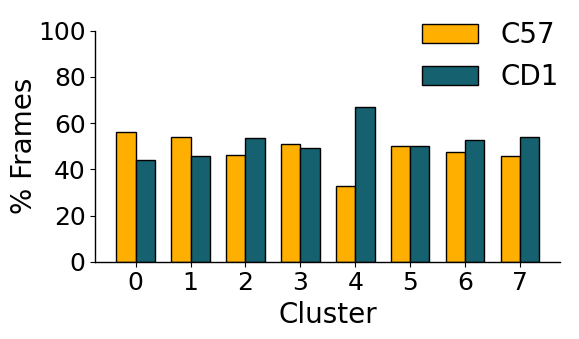

In [4]:
#calculate cluster percent per recording, and then average across recordings per strain 

cluster_grouping = clustered_df.groupby(['raw_kmeans_labels_zscore','Strain'])
strain_counts = cluster_grouping['Strain'].value_counts().unstack() 
strain_percentages = strain_counts.div(strain_counts.sum(axis=1), axis=0) * 100

# Get the number of clusters
num_clusters = strain_counts.shape[0]

# Set the width of each bar
bar_width = 0.35

# Create an array of cluster indices
cluster_indices = np.arange(num_clusters)

# Plot the bars for each strain next to each other
fig, ax = plt.subplots(figsize=(6, 3))
bar1 = ax.bar(cluster_indices - bar_width/2, strain_percentages.iloc[:, 0], 
              bar_width, label=strain_percentages.columns[0], 
              color = hex_2_rgb('#FFAF00'), edgecolor = 'k')
bar2 = ax.bar(cluster_indices + bar_width/2, strain_percentages.iloc[:, 1], 
              bar_width, label=strain_percentages.columns[1],
              color = hex_2_rgb('#15616F'), edgecolor = 'k')

# Add labels, title, and legend
ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylim(0,100)
ax.set_ylabel('% Frames', fontsize = 20, labelpad = 0)
#ax.set_title('Strain Percentage per Cluster', fontsize = 24)
ax.set_xticks(cluster_indices)
ax.legend(frameon = False, fontsize = 20, bbox_to_anchor = (1.05,1.15))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['bottom'].set_linewidth(1)  # X-axis
plt.gca().spines['left'].set_linewidth(1) 
# Show plot
plt.show()

[(0.6196078431372549, 0.00392156862745098, 0.25882352941176473), (0.8862745098039215, 0.3176470588235294, 0.2901960784313726), (0.9882352941176471, 0.6470588235294118, 0.36470588235294116), (0.996078431372549, 0.9529411764705882, 0.6), (0.8941176470588236, 0.9725490196078431, 0.6392156862745098), (0.6352941176470588, 0.8509803921568627, 0.6431372549019608), (0.2784313725490196, 0.6274509803921569, 0.7019607843137254), (0.3686274509803922, 0.30980392156862746, 0.6352941176470588)]


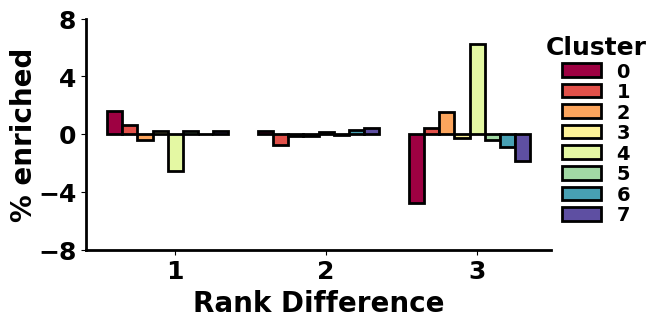

In [94]:
#potentially do one for CD1 and one for C57 potentially the same way we do the new cluster approach 

clustered_df['reward_comp_elo'] = pd.to_numeric(clustered_df['reward_comp_elo'], errors='coerce')

# Convert the column to integers
clustered_df['reward_comp_elo'] = clustered_df['reward_comp_elo'].astype(int)
#count rank dif per cluster
cluster_grouping = clustered_df.groupby(['raw_kmeans_labels_zscore','reward_comp_elo'])
rank_counts = cluster_grouping['reward_comp_elo'].value_counts().unstack()

#conver to percentage (cluster x rank diff y / total rank diff y) * 100 
rank_percentages = rank_counts.div(rank_counts.sum(axis=0), axis=1) * 100 
#count total frames per cluster
cluster_totals = clustered_df.groupby(['raw_kmeans_labels_zscore']).size()
#count total frames
total_frames = len(clustered_df)
#percent per cluster =  (cluster total / frames total) * 100
cluster_percents = (cluster_totals / total_frames) * 100

# % enrichment = rank_percent (i.e. cluster x rank diff/rank total)
# minus cluster percent (i.e. cluster total / total frames)
rank_percentages_enrichment = rank_percentages.sub(cluster_percents, axis = 0)

# Get the number of clusters
num_clusters = rank_counts.shape[0]
num_rankdif = rank_counts.shape[1]
cluster_width = 0.8 / num_clusters
cluster_indices = np.arange(num_clusters)
rank_indices = np.arange(num_rankdif)
bar_width = 0.1
# Plot the bars for each rank next to each other
colors = [hex_2_rgb('#9e0142'), hex_2_rgb('#e2514a'), hex_2_rgb('#fca55d'),
          hex_2_rgb('#fef399'), hex_2_rgb('#e4f8a3'), hex_2_rgb('#a2d9a4'),
          hex_2_rgb('#47a0b3'), hex_2_rgb('#5e4fa2')]
fig, ax = plt.subplots(figsize=(6, 3))
print(colors)
for i in cluster_indices:
    ax.bar(rank_indices + 1 + i * bar_width - 0.4, rank_percentages_enrichment.iloc[i, :], 
              bar_width, edgecolor = 'k',
              linewidth = 2,
              color = colors[i], label = i)

# Add labels, title, and legend
ax.set_xlabel('Rank Difference', fontsize = 20)
ax.set_ylim(-8,8)
ax.set_ylabel('% enriched', fontsize = 20, labelpad=0)
ax.set_yticks(range(-8,9,4))
#ax.set_title('Reward Comp Rank Differences per Cluster', fontsize = 24, y=1.1)
ax.set_xticks(rank_percentages.columns)
legend = ax.legend(frameon=False, fontsize=14, title='Cluster', title_fontsize=18,
                 bbox_to_anchor = (.95,1), labelspacing = 0.08, ncol = 1)

# Get the title text object from the legend
title_text = legend.get_title()
plt.subplots_adjust(wspace=0.1)
# Set the horizontal alignment to left
title_text.set_position((0,1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
# Show plot
plt.show()

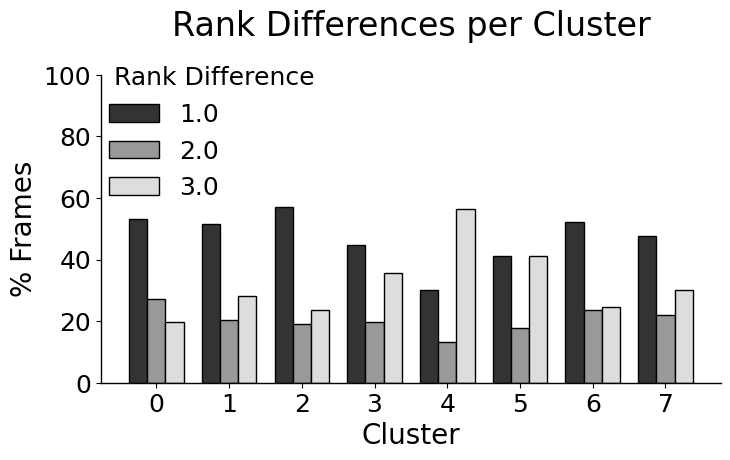

In [141]:
clustered_df['home_cage_observation_elo'] = pd.to_numeric(clustered_df['home_cage_observation_elo'], errors='coerce')

# Convert the column to integers
#clustered_df['home_cage_observation_elo'] = clustered_df['home_cage_observation_elo'].astype(int)
cluster_grouping = clustered_df.groupby(['raw_kmeans_labels_zscore','home_cage_observation_elo'])

strain_counts = cluster_grouping['home_cage_observation_elo'].value_counts().unstack()
strain_percentages = strain_counts.div(strain_counts.sum(axis=1), axis=0) * 100

# Get the number of clusters
num_clusters = strain_counts.shape[0]

# Set the width of each bar
bar_width = 0.25

# Create an array of cluster indices
cluster_indices = np.arange(num_clusters)

# Plot the bars for each strain next to each other
fig, ax = plt.subplots(figsize=(8, 4))
bar1 = ax.bar(cluster_indices - bar_width, strain_percentages.iloc[:, 0], 
              bar_width, label=strain_percentages.columns[0], edgecolor = 'k',
              color = hex_2_rgb('#333333'))
bar2 = ax.bar(cluster_indices, strain_percentages.iloc[:, 1], 
              bar_width, label=strain_percentages.columns[1], edgecolor = 'k',
              color = hex_2_rgb('#999999'))
bar3 = ax.bar(cluster_indices + bar_width, strain_percentages.iloc[:, 2], 
              bar_width, label=strain_percentages.columns[2], edgecolor = 'k',
              color = hex_2_rgb('#DDDDDD'))

# Add labels, title, and legend
ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylim(0,100)
ax.set_ylabel('% Frames', fontsize = 20)
ax.set_title('Rank Differences per Cluster', fontsize = 24, y=1.1)
ax.set_xticks(cluster_indices)
legend = ax.legend(frameon=False, fontsize=18, title='Rank Difference', title_fontsize=18,
                   bbox_to_anchor = (.3,1.1))

# Get the title text object from the legend
title_text = legend.get_title()

# Set the horizontal alignment to left
title_text.set_position((50,1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['bottom'].set_linewidth(1)  # X-axis
plt.gca().spines['left'].set_linewidth(1) 
# Show plot
plt.show()

[(0.6196078431372549, 0.00392156862745098, 0.25882352941176473), (0.8862745098039215, 0.3176470588235294, 0.2901960784313726), (0.9882352941176471, 0.6470588235294118, 0.36470588235294116), (0.996078431372549, 0.9529411764705882, 0.6), (0.8941176470588236, 0.9725490196078431, 0.6392156862745098), (0.6352941176470588, 0.8509803921568627, 0.6431372549019608), (0.2784313725490196, 0.6274509803921569, 0.7019607843137254), (0.3686274509803922, 0.30980392156862746, 0.6352941176470588)]


ConversionError: Failed to convert value(s) to axis units: Index(['10-03-22_Test_11_6-1v6-2', '10-03-22_Test_12_6-3v6-4',
       '10-03-22_Test_13_2-2v2-4', '10-03-22_Test_14_2-1v2-3',
       '10-03-22_Test_15_1-2v1-4', '10-03-22_Test_19_3-2v3-4',
       '10-03-22_Test_1_1-1v1-2', '10-03-22_Test_20_3-1v3-3',
       '10-03-22_Test_23_5-2v5-4', '10-03-22_Test_24_5-1v5-3',
       '10-03-22_Test_2_1-3v1-4', '10-03-22_Test_32_4-1v4-4',
       '10-03-22_Test_35_6-2v6-3', '10-03-22_Test_3_2-1v2-2',
       '10-03-22_Test_7_4-1v4-2', '10-03-22_Test_8_4-3v4-4',
       '10-04-22_Test_10_2-2v2-3', '10-04-22_Test_11_1-1v1-4',
       '10-04-22_Test_12_1-2v1-3', '10-04-22_Test_13_5-1v5-3',
       '10-04-22_Test_14_5-2v5-4', '10-04-22_Test_15_6-1v6-3',
       '10-04-22_Test_16_6-2v6-4', '10-04-22_Test_17_3-1v3-3',
       '10-04-22_Test_19_4-1v4-3', '10-04-22_Test_20_4-2v4-4',
       '10-04-22_Test_21_1-1v1-3', '10-04-22_Test_2_6-2v6-3',
       '10-04-22_Test_3_5-1v5-4', '10-04-22_Test_7_3-1v3-4',
       '10-04-22_Test_8_3-2v3-3', '10-04-22_Test_9_2-1v2-4'],
      dtype='object', name='Recording')

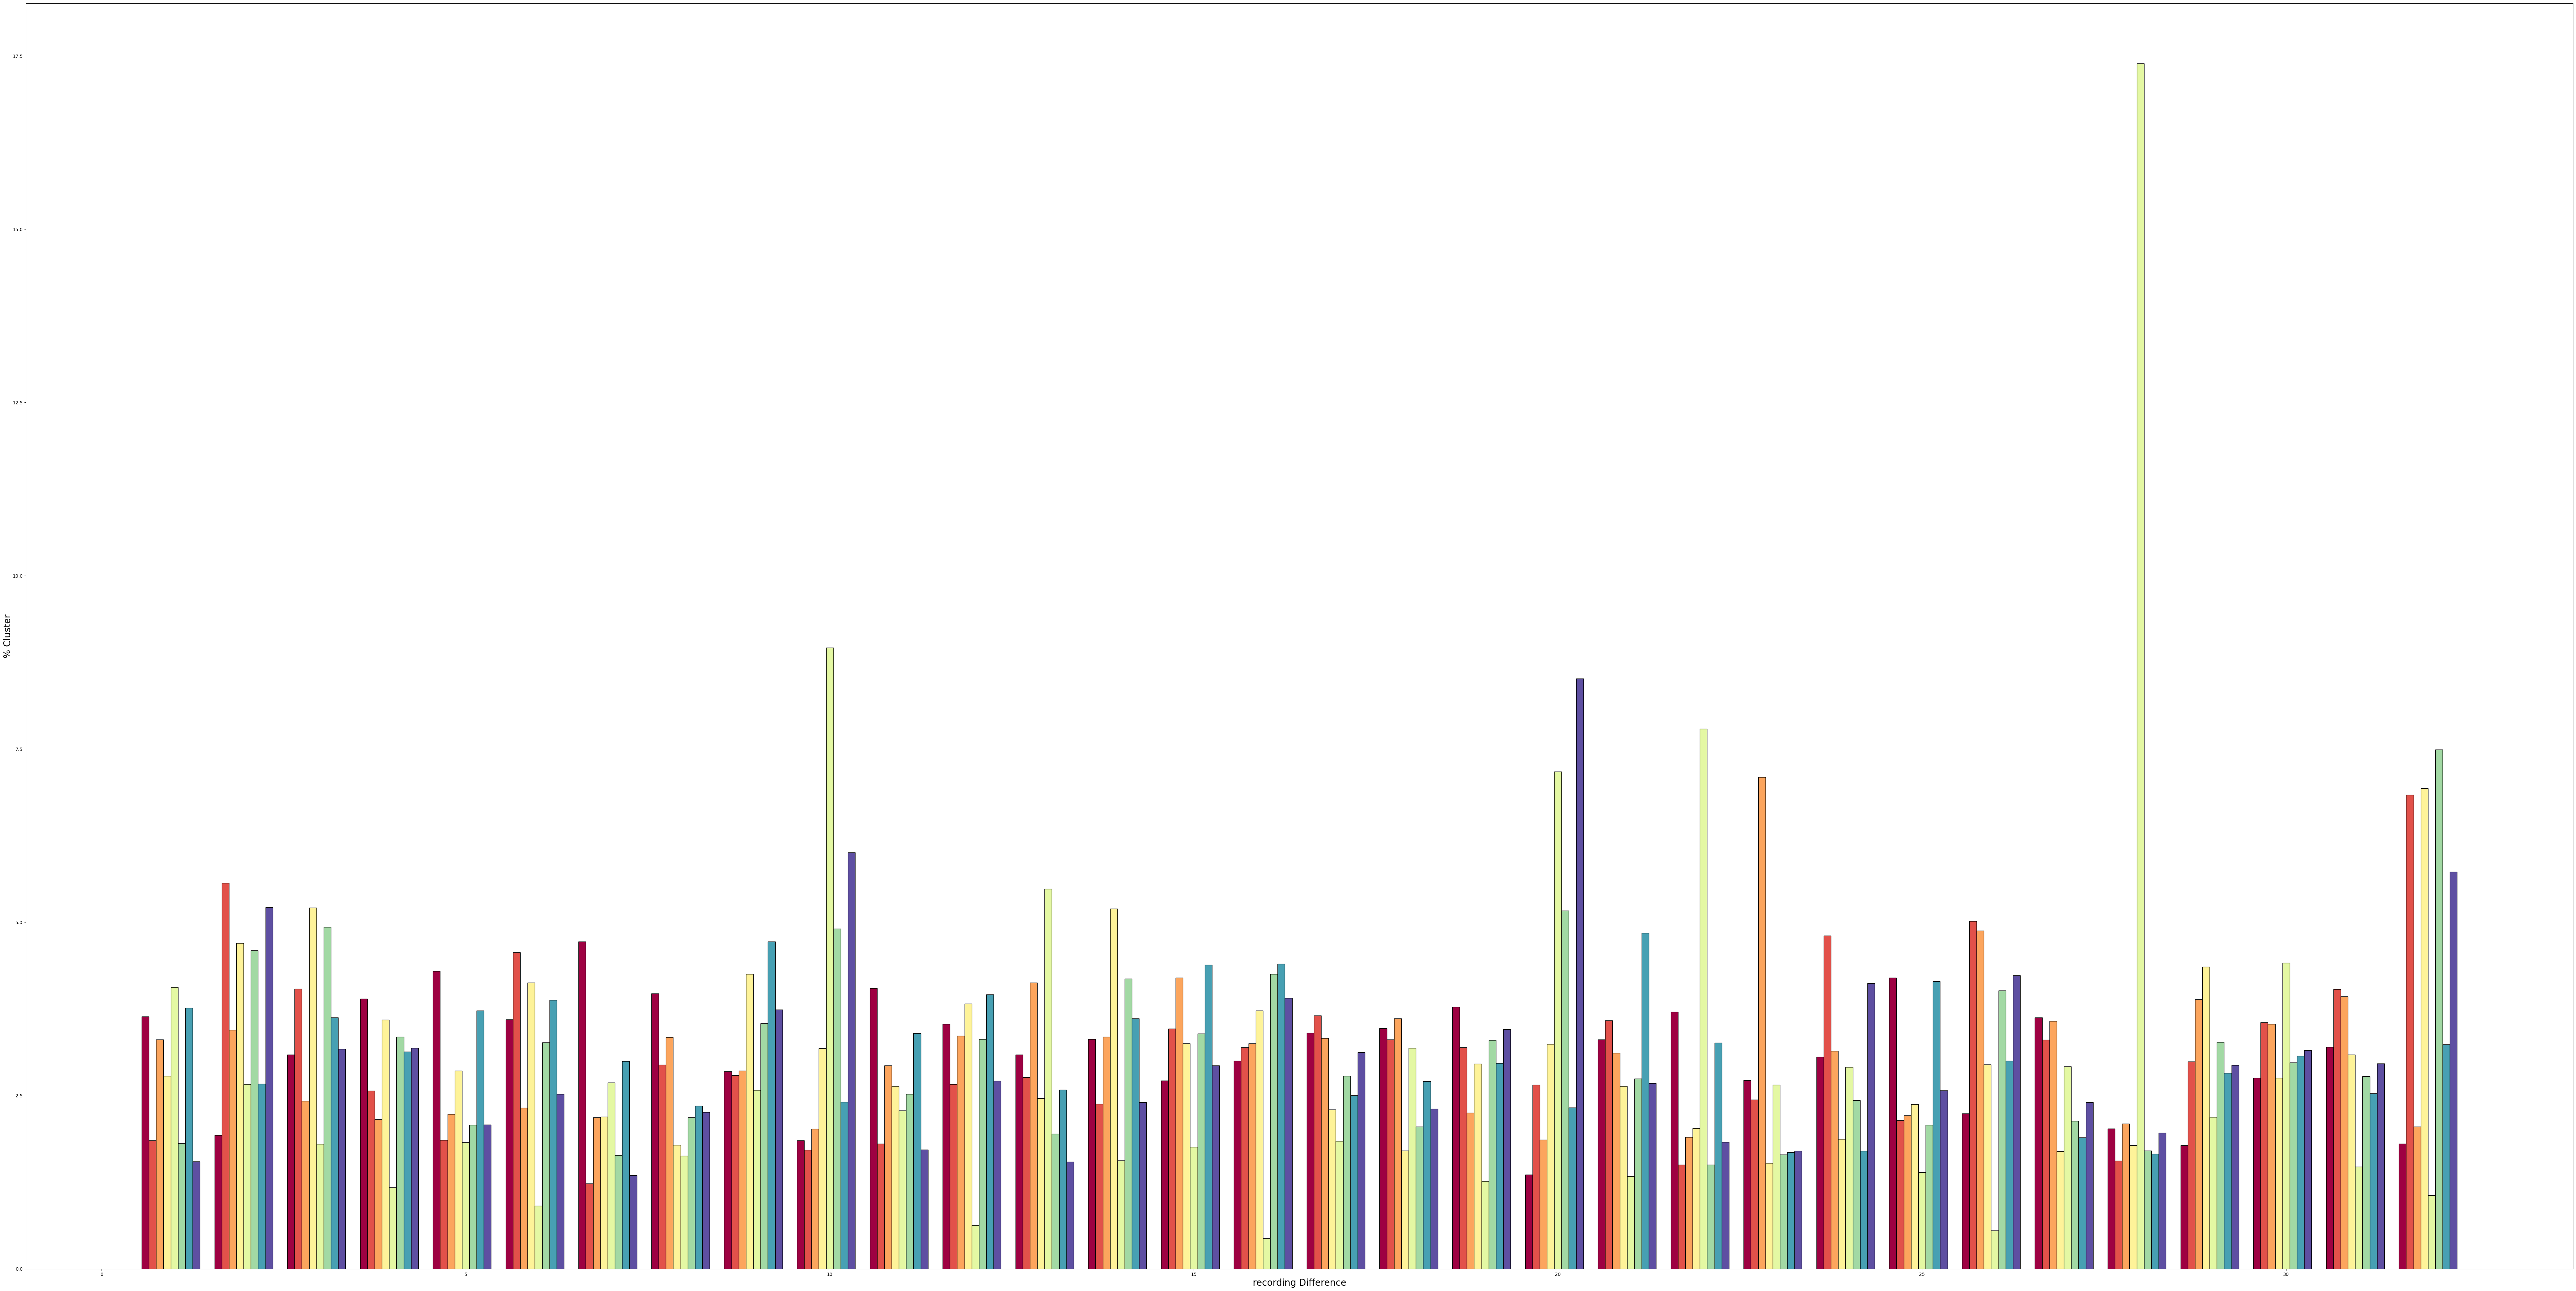

In [122]:



#count recording dif per cluster
cluster_grouping = clustered_df.groupby(['raw_kmeans_labels_zscore','Recording'])

recording_counts = cluster_grouping['Recording'].value_counts().unstack()
#conver to percentage (cluster x recording diff y / total recording diff y) * 100 
recording_percentages = recording_counts.div(recording_counts.sum(axis=1), axis=0) * 100 
#count total frames per cluster
#percent per cluster =  (cluster total / frames total) * 100

recording_percentages.reset_index(inplace=True)

# Set the index to 'raw_kmeans_labels_zscore'
recording_percentages.set_index('raw_kmeans_labels_zscore', inplace=True)

# Rename the columns to match the 'Recording' values


# % enrichment = recording_percent (i.e. cluster x recording diff/recording total)
# minus cluster percent (i.e. cluster total / total frames)

# Get the number of clusters
num_clusters = recording_counts.shape[0]
num_recordingdif = recording_counts.shape[1]
cluster_width = 0.8 / num_clusters
cluster_indices = np.arange(num_clusters)
recording_indices = np.arange(num_recordingdif)
bar_width = 0.1
# Plot the bars for each recording next to each other
colors = [hex_2_rgb('#9e0142'), hex_2_rgb('#e2514a'), hex_2_rgb('#fca55d'),
          hex_2_rgb('#fef399'), hex_2_rgb('#e4f8a3'), hex_2_rgb('#a2d9a4'),
          hex_2_rgb('#47a0b3'), hex_2_rgb('#5e4fa2')]
fig, ax = plt.subplots(figsize=(100, 50))
print(colors)
for i in cluster_indices:
    ax.bar(recording_indices + 1 + i * bar_width - 0.4, recording_percentages.iloc[i, :], 
              bar_width, edgecolor = 'k',
              color = colors[i], label = i)

# Add labels, title, and legend
ax.set_xlabel('recording Difference', fontsize = 20)
ax.set_ylabel('% Cluster', fontsize = 20, labelpad=0)
#ax.set_title('Reward Comp recording Differences per Cluster', fontsize = 24, y=1.1)
ax.set_xticks(recording_percentages.columns)
legend = ax.legend(frameon=False, fontsize=14, title='Cluster', title_fontsize=18,
                 bbox_to_anchor = (.95,1), labelspacing = 0.08, ncol = 1)

# Get the title text object from the legend
title_text = legend.get_title()
plt.subplots_adjust(wspace=0.1)
# Set the horizontal alignment to left
title_text.set_position((0,1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['bottom'].set_linewidth(1)  # X-axis
plt.gca().spines['left'].set_linewidth(1) 
# Show plot
plt.show()

In [99]:
clustered_df['Recording']

0         NaN
3         NaN
6         NaN
9         NaN
12        NaN
           ..
1776861   NaN
1776864   NaN
1776867   NaN
1776870   NaN
1776873   NaN
Name: Recording, Length: 592292, dtype: float64

### Trial


<Figure size 640x480 with 0 Axes>

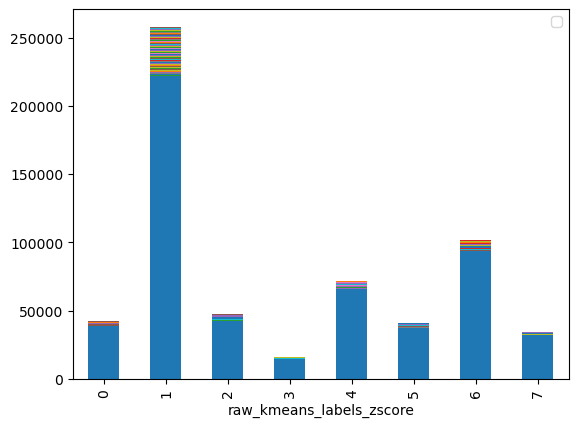

In [53]:
cluster_grouping_trial = subsample_df.groupby(['raw_kmeans_labels_zscore','trial_indice'])

trial_counts = cluster_grouping_trial['trial_indice'].value_counts().unstack()
plt.figure()
trial_counts.plot(kind='bar', stacked=True)    
plt.legend([]) 

Text(0.5, 1.0, 'Trial Time per cluster')

<Figure size 640x480 with 0 Axes>

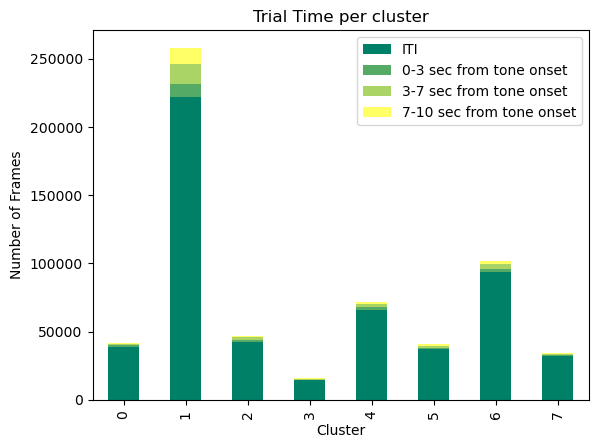

In [55]:
def categorize_trial_indices(value):
    value = float(value)
    if value == 0:
        return 'ITI'
    elif 0 < value <= 3:
        return '0-3 sec from tone onset'
    elif 3 < value <= 7:
        return '3-7 sec from tone onset'
    elif 7 < value <= 10:
        return '7-10 sec from tone onset'
    else:
        return None  
    

# Assign values based on the ranges
subsample_df['simplified_trial_indice'] = subsample_df['trial_indice'].apply(lambda x: categorize_trial_indices(x))
trial_colors = make_color_dict('simplified_trial_indice', subsample_df, 'summer')

cluster_grouping_trial = subsample_df.groupby(['raw_kmeans_labels_zscore','simplified_trial_indice'])

trial_counts = cluster_grouping_trial['simplified_trial_indice'].value_counts().unstack()
trial_counts = trial_counts[['ITI','0-3 sec from tone onset',
 '3-7 sec from tone onset',
 '7-10 sec from tone onset'
 ]]


plt.figure()
trial_counts.plot(kind='bar', stacked=True, color = trial_colors)    
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Number of Frames')
plt.title('Trial Time per cluster')


Text(0.5, 1.0, 'Trial Time per cluster')

<Figure size 640x480 with 0 Axes>

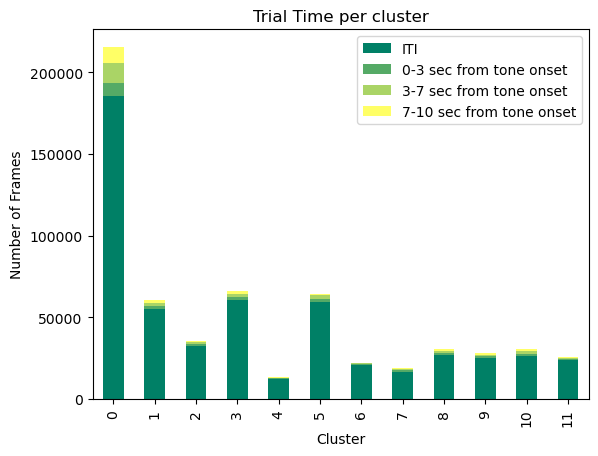

In [404]:

def categorize_trial_indices(value):
    value = float(value)
    if value == 0:
        return 'ITI'
    elif 0 < value <= 3:
        return '0-3 sec from tone onset'
    elif 3 < value <= 7:
        return '3-7 sec from tone onset'
    elif 7 < value <= 10:
        return '7-10 sec from tone onset'
    else:
        return None  
    

# Assign values based on the ranges
clustered_df['simplified_trial_indice'] = clustered_df['trial_indice'].apply(lambda x: categorize_trial_indices(x))
trial_colors = make_color_dict('simplified_trial_indice', clustered_df, 'summer')

cluster_grouping_trial = clustered_df.groupby(['raw_kmeans_labels','simplified_trial_indice'])

trial_counts = cluster_grouping_trial['simplified_trial_indice'].value_counts().unstack()
trial_counts = trial_counts[['ITI','0-3 sec from tone onset',
 '3-7 sec from tone onset',
 '7-10 sec from tone onset'
 ]]


plt.figure()
trial_counts.plot(kind='bar', stacked=True, color = trial_colors)    
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Number of Frames')
plt.title('Trial Time per cluster')


## Ethogram

In [ ]:
#create a color dictionary based on the colors chosen by cmap: spectra 
# for the cluster plotting to use in later plots 
plt.rcdefaults()
cluster_colors = make_color_dict('raw_kmeans_labels_zscore', clustered_df)
print(cluster_colors)



cluster_colors = {0: (np.append(np.array(hex_2_rgb('#9E0142')), 1)), 
                  1: (np.append(np.array(hex_2_rgb('#E2514A')), 1)),
                  2: (np.append(np.array(hex_2_rgb('#FCA55D')), 1)),
                  3: (np.append(np.array(hex_2_rgb('#FEE999')), 1)),
                  4: (np.append(np.array(hex_2_rgb('#EDF8A3')), 1)),
                  5: (np.append(np.array(hex_2_rgb('#A2D9A4')), 1)),
                  6: (np.append(np.array(hex_2_rgb('#47A0B3')), 1)),
                  7: (np.append(np.array(hex_2_rgb('#5E4FA2')), 1))}
colors = list(cluster_colors.values())
palette = sns.color_palette(colors)
palette

In [5]:
# goal is to create a bar graph for one recording 
file = '10-03-22_Test_23_5-2v5-4'
tester_df = clustered_df[clustered_df['Recording'] == file]
tester_df[['frame indice', 'raw_kmeans_labels_zscore']]

frame indice  raw_kmeans_labels_zscore
148792           0.0                         0
148793           3.0                         0
148794           6.0                         0
148795           9.0                         0
148796          12.0                         0
...              ...                       ...
167335       55629.0                         3
167336       55632.0                         3
167337       55635.0                         3
167338       55638.0                         3
167339       55641.0                         3

[18548 rows x 2 columns]

In [6]:
def get_indices(df, cluster_label):
    """
    Takes in an indexed key or a list of repeated items, 
    creates a list of indices that correspond to each unique item. 
    
    Args (1):
        repeated_items_list: list, list of repeated items 
    
    Returns:
        item_indices: list of tuples, where the first element is the first index 
                      of an item, and the second element is the last index of that 
                      item 
    """
    is_first = True
    item_indices = {}
    durations = {}
    for i in range(len(df)):
        if is_first:
            current_item = df.iloc[i][cluster_label]
            start_index = df.iloc[i]['frame indice']
            current_recording = df.iloc[i]['Recording']
            start_index = float(start_index)/30/60
            is_first = False
        if df.iloc[i]['Recording'] != current_recording:
            end_index = df.iloc[i-1]['frame indice']
            end_index = float(end_index)/30/60
            indice_list = item_indices[current_item]
            indice_list.append([start_index,end_index])
            durations[current_item].append(end_index - start_index)
            item_indices[current_item] = indice_list
            current_recording = df.iloc[i]['Recording']
            start_index = df.iloc[i]['frame indice']
            start_index = float(start_index)/30/60
        if i == (len(df)-1):
            end_index = df.iloc[i]['frame indice']
            end_index = float(end_index)/30/60
            indice_list = item_indices[current_item]
            indice_list.append([start_index,end_index])
            durations[current_item].append(end_index - start_index)
            item_indices[current_item] = indice_list
        if (not is_first) & (df.iloc[i]['Recording'] == current_recording):
            if df.iloc[i][cluster_label] != current_item:
                end_index = df.iloc[i]['frame indice']
                stop_index = df.iloc[i-1]['frame indice']
                stop_index = float(stop_index)/30/60
                end_index = float(end_index)/30/60
                if current_item in item_indices.keys():
                    indice_list = item_indices[current_item]
                    indice_list.append([start_index,stop_index])
                    durations[current_item].append(end_index - start_index)
                    item_indices[current_item] = indice_list
                else: 
                    item_indices[current_item] = [[start_index, stop_index]]
                    durations[current_item] = [end_index - start_index]
                start_index = df.iloc[i]['frame indice']
                start_index = float(start_index)/30/60
                current_item = df.iloc[i][cluster_label] 
    return item_indices, durations

cluster_dict, durations = get_indices(clustered_df, 'raw_kmeans_labels_zscore')

recording_cluster_dict, tester_durations = get_indices(tester_df, 'raw_kmeans_labels_zscore')

  

In [55]:
simplified_df = tester_df
simplified_df['labels'] = simplified_df['raw_kmeans_labels_zscore'].apply(lambda x: 'non-competitive' if 1 <= x <= 7 else 'competitive')

simp_cluster_dict, simp_durations = get_indices(simplified_df, 'labels')

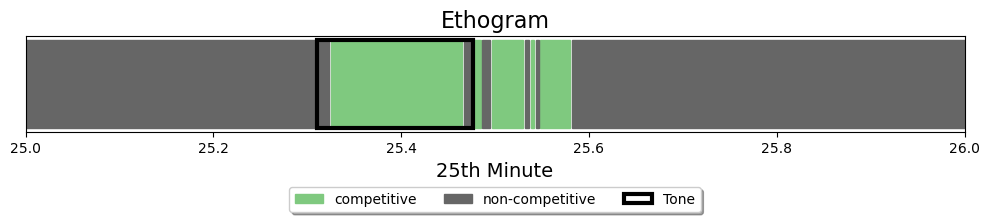

In [70]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(simp_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed
comp_colors = make_color_dict('labels', simplified_df, cmap = 'Accent')
for i, cluster_label in enumerate(y_labels):
    start_stops = simp_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = comp_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("25th Minute", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 25.31, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.set_xlim((25,26))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.savefig('25min_ethogram.svg', format='svg')
plt.show()



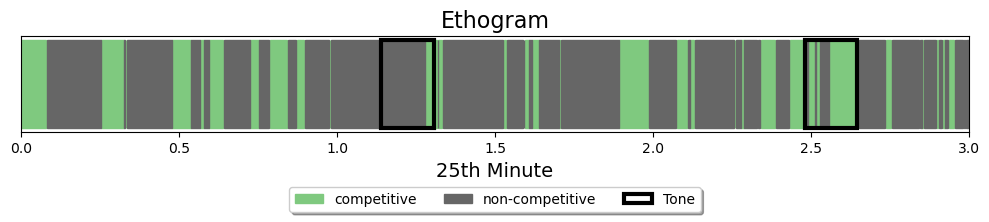

In [69]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(simp_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed
#comp_colors = make_color_dict('labels', simplified_df)
for i, cluster_label in enumerate(y_labels):
    start_stops = simp_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = comp_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("25th Minute", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 1.14, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.barh(1, .167, left = 2.48, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3)
ax.set_xlim((0,3))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.savefig('3min_ethogram.svg', format='svg')
plt.show()


In [7]:
avg_durations = {}
for cluster, duration in tester_durations.items():
    duration_min = np.array(duration)*60
    avg_duration = np.mean(duration_min)
    med_durations = np.median(duration_min)
    max_beh = np.max(duration_min)
    min_beh = np.min(duration_min)
    no_events = len(duration)
    avg_durations[cluster] = [avg_duration, med_durations, max_beh, min_beh, no_events]
    

tester_cluster_info = pd.DataFrame.from_dict(avg_durations, orient = 'index')
tester_cluster_info.columns = ['Average Duration (s)','Median (s)', 'Max (s)', 'Min(s)', 'Number of events']
tester_cluster_info

Average Duration (s)  Median (s)  Max (s)  Min(s)  Number of events
0              1.645244         0.9     25.5     0.1               431
2              0.930164         0.4     10.4     0.1               305
6              0.348321         0.3      1.2     0.1               536
5              0.278436         0.2      1.6     0.1               422
7              1.274020         0.7     11.1     0.1               204
1              0.601579         0.3      4.4     0.1               190
3              0.398788         0.4      1.1     0.1               165
4              0.871852         0.4     12.7     0.1               135

In [8]:
avg_durations = {}
for cluster, duration in durations.items():
    duration_min = np.array(duration)*60
    avg_duration = np.mean(duration_min)
    med_durations = np.median(duration_min)
    max_beh = np.max(duration_min)
    min_beh = np.min(duration_min)
    no_events = len(duration)
    avg_durations[cluster] = [avg_duration, med_durations, max_beh]#, min_beh]#, no_events]
    

cluster_info = pd.DataFrame.from_dict(avg_durations, orient = 'index')
cluster_info.columns = ['Average Duration (s)','Median (s)', 'Max (s)'] #'Min(s)']#, 'Number of events']
cluster_info

Average Duration (s)  Median (s)  Max (s)
7              1.370637         0.8     22.7
3              0.388950         0.4      1.4
5              0.322762         0.2      4.3
1              0.810436         0.4     32.2
6              0.345189         0.3      2.4
0              2.500281         1.2     62.4
4              1.019817         0.4     76.9
2              1.265689         0.6     33.3

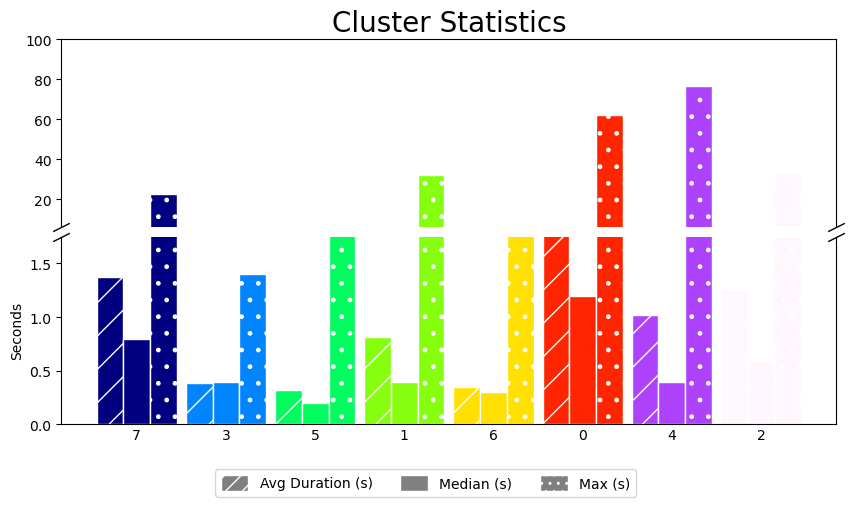

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,5), sharex=True, facecolor='white')
fig.subplots_adjust(hspace=0.05) 
import matplotlib.patches as mpatches

colors = list(cluster_colors.values())
fills = ['/','','.']*10
# Loop through each cluster (index) and plot the bars
for i, cluster in enumerate(cluster_info.index):
    cluster_data = cluster_info.loc[cluster]
    bar_width = 0.3
    x_positions = [i + bar_width * j for j in range(len(cluster_data))]
    for j, (x, value) in enumerate(zip(x_positions, cluster_data)):
        hatch_pattern = fills[j % len(fills)]  # Use modulo to cycle through fill patterns
        # Plot on the first subplot (0-1 on y-axis)
        ax1.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern, edgecolor='white')
        # Plot on the second subplot (0-1 on y-axis)
        ax2.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern, edgecolor='white')
        if j == len(x_positions) // 2:  # Assuming the middle bar is at index len(x_positions) // 2
            ax1.text(x, -2, f'{cluster}', ha='center', va='center')
            ax2.text(x, -0.1, f'{cluster}', ha='center', va='center')
    #ax1.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
    #ax2.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
# ax2.set_xticks([j + 1.5 * bar_width * i for i in range(len(cluster_info.columns)) for j in range(len(cluster_info))])
# ax2.set_xticklabels([col for col in cluster_info.columns for _ in range(len(cluster_info))], rotation=45, ha='right')
ax1.set_ylim(6, 100)  # outliers only
ax2.set_ylim(0, 1.75)  # most of the data

# hide the spines between ax and ax2
 # don't put tick labels at the top

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
# Set labels and title


ax2.set_ylabel('Seconds')
ax1.set_title('Cluster Statistics', fontsize = 20)

# Add legend

cluster_labels = []
for cluster, color in cluster_colors.items():
    cluster_labels.append(mpatches.Patch(facecolor=color,  label=cluster))
                          
#ax1.legend(handles = cluster_labels, bbox_to_anchor=(.9,-1.1), ncol=10)                   
patch_max = mpatches.Patch(facecolor='gray', hatch='..', label='Max (s)', edgecolor='white')
patch_avg = mpatches.Patch(facecolor='gray', hatch='//', label='Avg Duration (s)',edgecolor='white')
patch_median = mpatches.Patch(facecolor='gray', hatch='', label='Median (s)',edgecolor='white')

# Plotting empty bars to display the legend
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labelbottom=False, bottom=False)
ax2.tick_params(labelbottom=False, bottom=False)   


# Create the legend
ax2.legend(handles=[ patch_avg, patch_median, patch_max], bbox_to_anchor=(.75,-.2), ncol= 3, handleheight=1.5)
ax1.grid(False)
ax2.grid(False)

# Show the plot
plt.show()



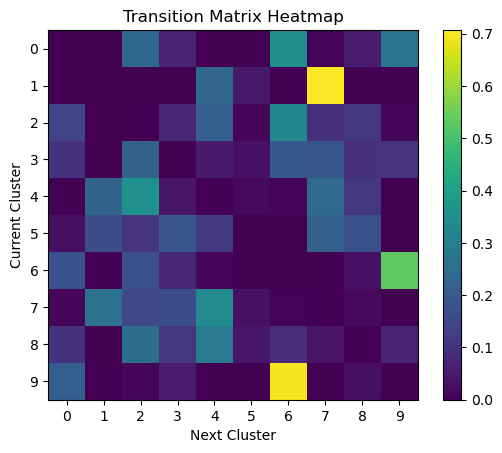

In [ ]:
states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_states = len(states)
# Example sequence of transitions
transitions = np.array(clustered_df['kmeans_label'])
transitions = transitions[np.append([True], np.diff(transitions) != 0)]
# Create a transition matrix
transition_matrix = np.zeros((len(states), len(states)))

# Populate the transition matrix
for i in range(len(transitions) - 1):
    current_state = transitions[i]
    next_state = transitions[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize to get probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Print the transition matrix
plt.imshow(transition_matrix, cmap='viridis', interpolation='nearest')

# Adding colorbar
plt.colorbar()

# Adding labels and title
plt.xlabel('Next Cluster')
plt.ylabel('Current Cluster')
plt.title('Transition Matrix Heatmap')
plt.xticks(np.arange(num_states), np.arange(num_states))

# Set y-axis ticks and labels
plt.yticks(np.arange(num_states), np.arange(num_states))
# Show the plot
plt.show()

No handles with labels found to put in legend.


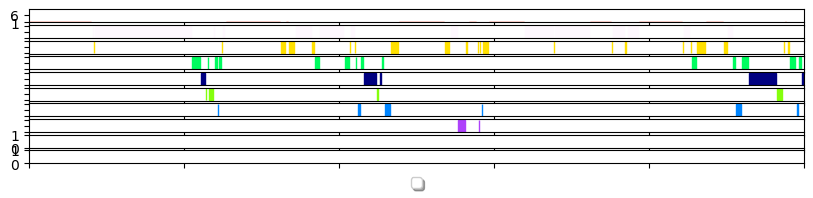

In [88]:
fig, axs = plt.subplots(figsize=(10, 2), nrows=10, ncols=1, sharex=True)
y_labels = list(recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
i = 0
bar_height = 1

for cluster_label in y_labels:
    start_stops = recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]
    # color
    bar_color = cluster_colors[cluster_label]
    axs[i].barh(
        0,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )
    axs[i].set_xticklabels('')
    axs[i].set_yticklabels('')
    axs[i].set_xlim((0,1))
    i += 1

axs[0].set_ylim(bottom=0, top=(max_len * par1) + par1)
pos = np.arange(par1, max_len * par1 + par1 + 1, par1)

# Adjust y-axis ticks and labels
#axs[0].set_yticks(pos[: len(y_labels)])
axs[0].set_yticklabels(y_labels)  # Use the cluster labels as y-axis tick labels

# axs[0].set_ylabel("Cluster")
# axs[0].grid(color="g", linestyle=":")
# axs[0].set_xlabel("Minute")
# axs[0].invert_yaxis()


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=10)
plt.tight_layout()
plt.show()

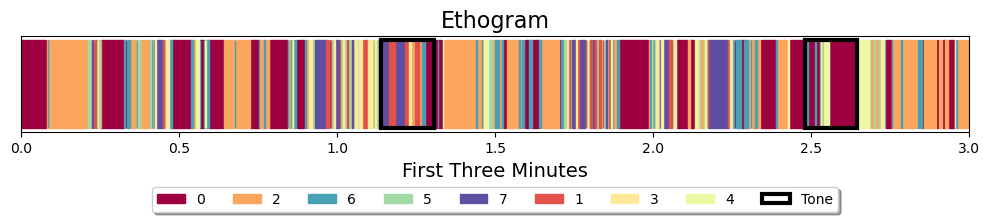

In [48]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed

for i, cluster_label in enumerate(y_labels):
    start_stops = recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = cluster_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("First Three Minutes", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 1.14, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.barh(1, .167, left = 2.48, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3)
#1.14277778,  2.47611111
ax.set_xlim((0,3))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.show()

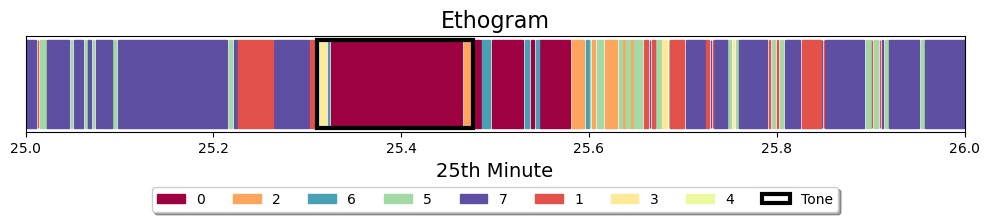

In [49]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed

for i, cluster_label in enumerate(y_labels):
    start_stops = recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = cluster_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("25th Minute", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 25.31, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.set_xlim((25,26))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.show()

In [329]:
tester_tones = tone_times_df[tone_times_df['File Name'] ==file]
tester_tones

File Name Frame Start  FPS Strain  \
22  10-03-22_Test_23_5-2v5-4        2057   29    CD1   

                                       all_tone_frame  
22  [2057, 4457, 7157, 9557, 11807, 14807, 17657, ...

In [330]:
tester_tones = list(tester_tones['all_tone_frame'])
tester_tones = tester_tones[0]
tester_tones = np.array(tester_tones) / 30 / 60


In [331]:
tester_tones

array([ 1.14277778,  2.47611111,  3.97611111,  5.30944444,  6.55944444,
        8.22611111,  9.80944444, 11.30944444, 12.64277778, 14.14277778,
       15.80944444, 17.30944444, 19.30944444, 20.80944444, 22.22611111,
       23.72611111, 25.30944444, 27.30944444, 28.64277778, 30.22611111,
       31.55944444, 33.05944444, 34.39277778, 35.64277778, 37.30944444,
       38.89277778, 40.39277778, 41.72611111, 43.22611111, 44.89277778,
       46.39277778, 48.39277778, 49.89277778, 51.30944444, 52.80944444,
       54.39277778, 55.89277778, 57.22611111, 58.72611111, 60.39277778,
       61.89277778, 63.39277778, 64.89277778, 66.39277778, 67.89277778,
       69.39277778, 70.89277778, 72.39277778, 73.89277778, 75.39277778,
       76.89277778, 78.39277778, 79.89277778, 81.39277778, 82.89277778,
       84.39277778, 85.89277778, 87.39277778, 88.89277778, 90.39277778])

### Raw clustering Stats


In [378]:
# goal is to create a bar graph for one recording 
file = '10-03-22_Test_23_5-2v5-4'
tester_df = clustered_df[clustered_df['Recording'] == file]
tester_df[['frame indice', 'raw_kmeans_labels']]

frame indice  raw_kmeans_labels
502329          2.0                  1
502332          5.0                  1
502335          8.0                  1
502338         11.0                  1
502341         14.0                  1
...             ...                ...
557955      55628.0                  5
557958      55631.0                  5
557961      55634.0                  5
557964      55637.0                  5
557967      55640.0                  5

[18547 rows x 2 columns]

In [379]:
raw_cluster_dict, raw_durations = get_indices(clustered_df, 'raw_kmeans_labels')

raw_recording_cluster_dict, raw_tester_durations = get_indices(tester_df, 'raw_kmeans_labels')

In [381]:
avg_durations = {}
for cluster, duration in raw_durations.items():
    duration_min = np.array(duration)*60
    avg_duration = np.mean(duration_min)
    med_durations = np.median(duration_min)
    max_beh = np.max(duration_min)
    min_beh = np.min(duration_min)
    no_events = len(duration)
    avg_durations[cluster] = [avg_duration, med_durations, max_beh]#, min_beh]#, no_events]
    

cluster_info = pd.DataFrame.from_dict(avg_durations, orient = 'index')
cluster_info.columns = ['Average Duration (s)','Median (s)', 'Max (s)'] #'Min(s)']#, 'Number of events']
cluster_info

Average Duration (s)  Median (s)  Max (s)
4              1.168590         0.6     18.3
8              0.263044         0.2      3.1
5              0.320414         0.3      1.3
6              0.964765         0.3     22.0
2              0.690744         0.3     26.9
7              0.508374         0.2     22.7
0              0.256560         0.2      1.4
1              1.800796         0.7     62.6
9              0.911510         0.4     66.4
3              0.654481         0.2     35.3

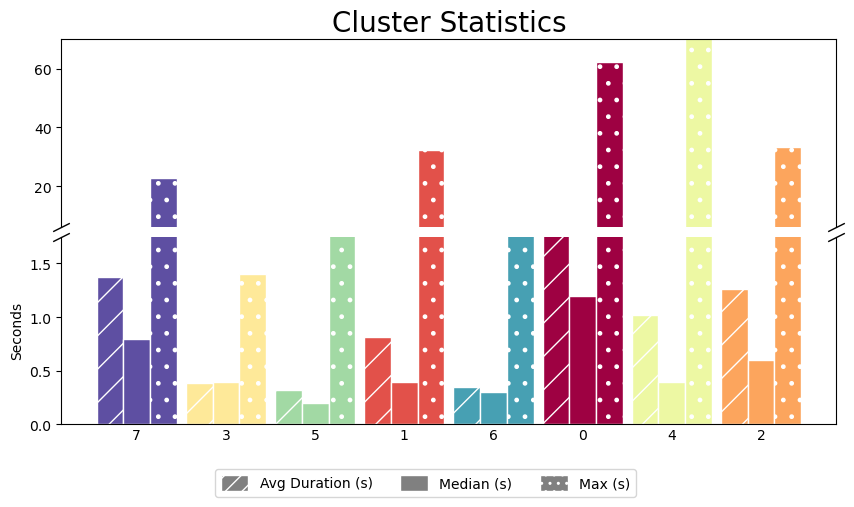

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,5), sharex=True, facecolor='white')
fig.subplots_adjust(hspace=0.05) 
import matplotlib.patches as mpatches

colors = list(cluster_colors.values())
fills = ['/','','.']*10
# Loop through each cluster (index) and plot the bars
for i, cluster in enumerate(cluster_info.index):
    cluster_data = cluster_info.loc[cluster]
    bar_width = 0.3
    x_positions = [i + bar_width * j for j in range(len(cluster_data))]
    for j, (x, value) in enumerate(zip(x_positions, cluster_data)):
        hatch_pattern = fills[j % len(fills)]  # Use modulo to cycle through fill patterns
        # Plot on the first subplot (0-1 on y-axis)
        ax1.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern, edgecolor='white')
        # Plot on the second subplot (0-1 on y-axis)
        ax2.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern, edgecolor='white')
        if j == len(x_positions) // 2:  # Assuming the middle bar is at index len(x_positions) // 2
            ax1.text(x, -2, f'{cluster}', ha='center', va='center')
            ax2.text(x, -0.1, f'{cluster}', ha='center', va='center')
    #ax1.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
    #ax2.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
# ax2.set_xticks([j + 1.5 * bar_width * i for i in range(len(cluster_info.columns)) for j in range(len(cluster_info))])
# ax2.set_xticklabels([col for col in cluster_info.columns for _ in range(len(cluster_info))], rotation=45, ha='right')
ax1.set_ylim(6, 70)  # outliers only
ax2.set_ylim(0, 1.75)  # most of the data

# hide the spines between ax and ax2
 # don't put tick labels at the top

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
# Set labels and title


ax2.set_ylabel('Seconds')
ax1.set_title('Cluster Statistics', fontsize = 20)

# Add legend

cluster_labels = []
for cluster, color in cluster_colors.items():
    cluster_labels.append(mpatches.Patch(facecolor=color,  label=cluster))
                          
#ax1.legend(handles = cluster_labels, bbox_to_anchor=(.9,-1.1), ncol=10)                   
patch_max = mpatches.Patch(facecolor='gray', hatch='..', label='Max (s)', edgecolor='white')
patch_avg = mpatches.Patch(facecolor='gray', hatch='//', label='Avg Duration (s)',edgecolor='white')
patch_median = mpatches.Patch(facecolor='gray', hatch='', label='Median (s)',edgecolor='white')

# Plotting empty bars to display the legend
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labelbottom=False, bottom=False)
ax2.tick_params(labelbottom=False, bottom=False)   


# Create the legend
ax2.legend(handles=[ patch_avg, patch_median, patch_max], bbox_to_anchor=(.75,-.2), ncol= 3, handleheight=1.5)
ax1.grid(False)
ax2.grid(False)

# Show the plot
plt.show()


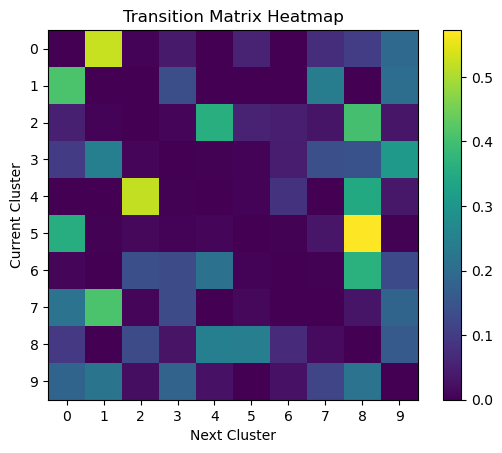

In [383]:
states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_states = len(states)
# Example sequence of transitions
transitions = np.array(clustered_df['raw_kmeans_labels'])
transitions = transitions[np.append([True], np.diff(transitions) != 0)]
# Create a transition matrix
transition_matrix = np.zeros((len(states), len(states)))

# Populate the transition matrix
for i in range(len(transitions) - 1):
    current_state = transitions[i]
    next_state = transitions[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize to get probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Print the transition matrix
plt.imshow(transition_matrix, cmap='viridis', interpolation='nearest')

# Adding colorbar
plt.colorbar()

# Adding labels and title
plt.xlabel('Next Cluster')
plt.ylabel('Current Cluster')
plt.title('Transition Matrix Heatmap')
plt.xticks(np.arange(num_states), np.arange(num_states))

# Set y-axis ticks and labels
plt.yticks(np.arange(num_states), np.arange(num_states))
# Show the plot
plt.show()

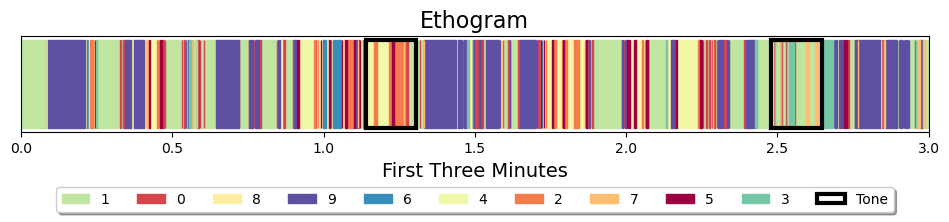

In [387]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(raw_recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed

for i, cluster_label in enumerate(y_labels):
    start_stops = raw_recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = cluster_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("First Three Minutes", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 1.14, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.barh(1, .167, left = 2.48, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3)
#1.14277778,  2.47611111
ax.set_xlim((0,3))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.show()

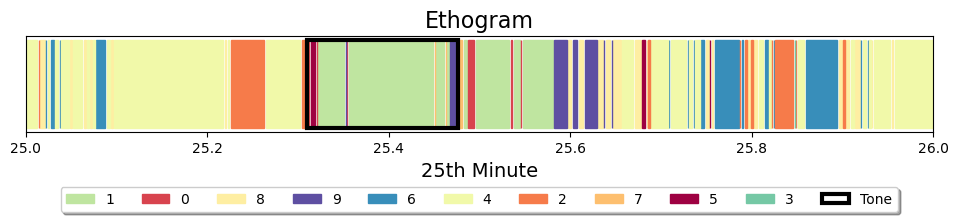

In [388]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(raw_recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed

for i, cluster_label in enumerate(y_labels):
    start_stops = raw_recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = cluster_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("25th Minute", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 25.31, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.set_xlim((25,26))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.show()